In [1]:
import pandas as pd
import numpy as np
import math
import os
import matplotlib.pyplot as plt
plt.style.use('seaborn')

/tmp/ipykernel_23057/1155928800.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
import warnings
warnings.filterwarnings("ignore")
warnings.resetwarnings()

In [3]:
df = pd.read_csv('all_data.csv', index_col=[0], parse_dates=True)
df.head()

,Price,Open,High,Low,Change_%,DayOfWeek
Date,,,,,,
2000-01-03,289.00,288.50,289.00,289.00,0.26,Monday
2000-01-04,282.45,288.75,282.45,282.45,-2.27,Tuesday
2000-01-05,281.00,281.50,281.00,281.00,-0.51,Wednesday
2000-01-06,281.23,280.12,281.23,281.23,0.08,Thursday
2000-01-07,281.75,281.15,281.75,281.75,0.18,Friday


In [4]:
df = df['Price']

In [5]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

def get_test_start_date(number_of_months):
    test_index_start = df.index[-1] - relativedelta(months=number_of_months)
    return test_index_start

In [6]:
def my_train_test_split(number_of_months, train_start_date):
    test_index_start = get_test_start_date(number_of_months)
    train, test = df[((df.index < test_index_start) & (df.index > train_start_date))], df[df.index >= test_index_start]
    return train, test    

In [7]:
train, test = my_train_test_split(3, '2015-01-01')

In [8]:
train.head(), len(train)

(Date
 2015-01-02    1189.18
 2015-01-05    1204.45
 2015-01-06    1219.20
 2015-01-07    1210.80
 2015-01-08    1208.98
 Name: Price, dtype: float64,
 2194)

In [9]:
train.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 2194 entries, 2015-01-02 to 2023-06-06
Series name: Price
Non-Null Count  Dtype  
--------------  -----  
2194 non-null   float64
dtypes: float64(1)
memory usage: 34.3 KB


In [10]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from datetime import datetime

In [11]:
def get_model_fit(train, lags):
    model = AutoReg(train, lags)
    model_fit = model.fit()
    return model_fit

In [12]:
model_fit = get_model_fit(train, lags=20)

/home/omar/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [13]:
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=True)

rmse = np.sqrt(mean_squared_error(test, predictions))
print(rmse)

43.203599924653965


/home/omar/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/omar/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: DeprecationWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/omar/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


In [14]:
predictions.index = test.index
predictions.head()

Date
2023-06-07    1963.086486
2023-06-08    1964.260013
2023-06-09    1966.734172
2023-06-12    1966.242559
2023-06-13    1966.092050
dtype: float64

In [15]:
def plot_test_predictions(test, predictions):
    plt.figure(figsize=(10, 6))
    plt.plot(test, label='Actual')
    plt.plot(predictions, color='red', label='Predicted')
    plt.title(f'AR Model Prediction')
    plt.xlabel('Time')
    plt.ylabel('Price')    
    plt.ylim([1700, 2200])
    plt.legend()
    plt.show()


In [16]:
def plot_test_predictions_with_params(test, predictions, rmse, start_date, lags):
    plt.figure(figsize=(10, 6))
    plt.plot(test, label='Actual')
    plt.plot(predictions, color='red', label='Predicted')
    plt.title(f'AR Model Prediction RMSE={rmse}, Start Date={start_date}, Lags={lags}')
    plt.xlabel('Time')
    plt.ylabel('Price')    
    plt.ylim([1700, 2200])
    plt.legend()
    plt.show()


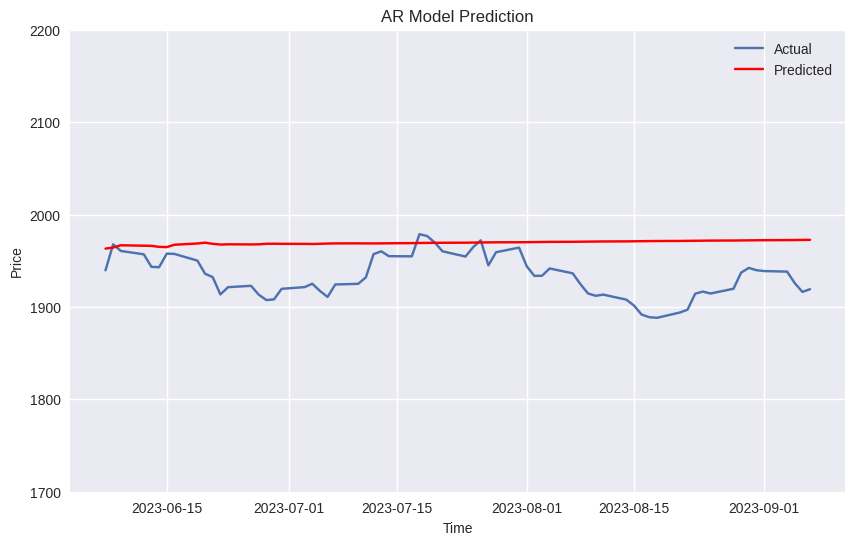

In [17]:
plot_test_predictions(test, predictions)

In [20]:
import itertools

# Define parameter combinations to try
start_dates = ['2000-01-01', '2006-01-01', '2012-01-01', '2015-01-01', '2018-01-01', '2020-01-01', '2021-01-01', '2022-01-01']
lags_values = [3, 6, 10, 15, 20, 30, 50, 75, 100]

best_rmse = float('inf')
best_params = None
models = dict()

for start_date, lags in itertools.product(start_dates, lags_values):
    
    train, test = my_train_test_split(1, start_date)
    model_fit = get_model_fit(train, lags)
        
    start=len(train)
    end=len(train) + len(test) - 1

    # Make predictions
    predictions = model_fit.predict(start=start, end=end, dynamic=False)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test, predictions))
    predictions.index = test.index
    models[model_fit] = (predictions, test, rmse, start_date, lags)

    if rmse < best_rmse:
        best_rmse = rmse
        best_params = (start_date, lags)
        best_model = model_fit


/home/omar/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/omar/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/omar/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: DeprecationWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/omar/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support ex

In [21]:
print("Best RMSE:", best_rmse)
print("Best Parameters (start_date, lags, dynamic):", best_params)

Best RMSE: 17.510397456889812
Best Parameters (start_date, lags, dynamic): ('2022-01-01', 30)


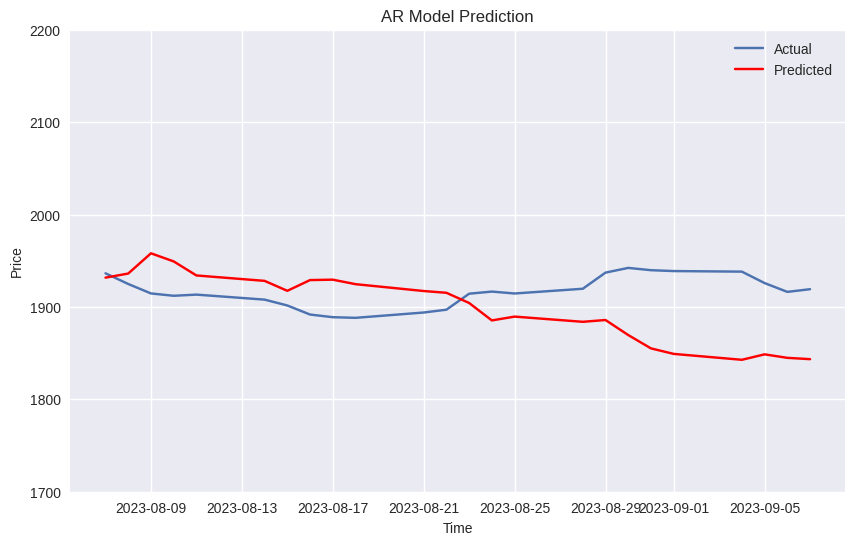

In [22]:
plot_test_predictions(test, predictions)

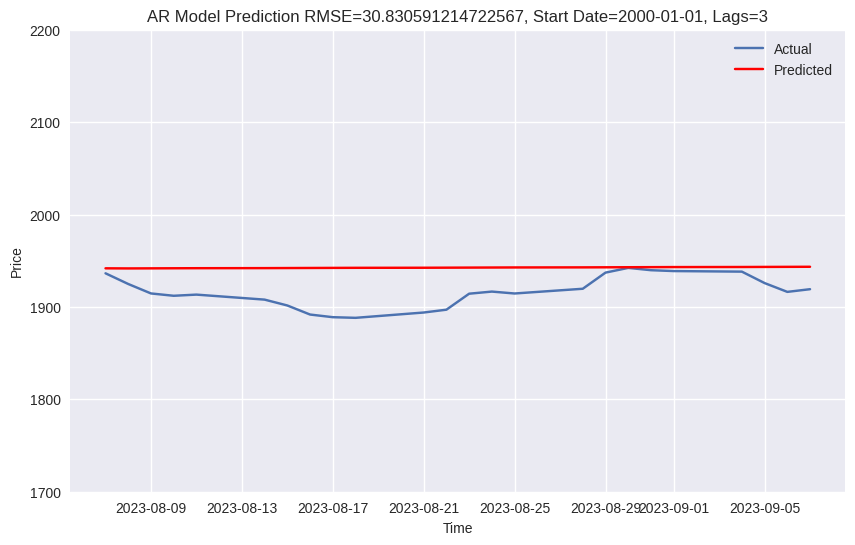

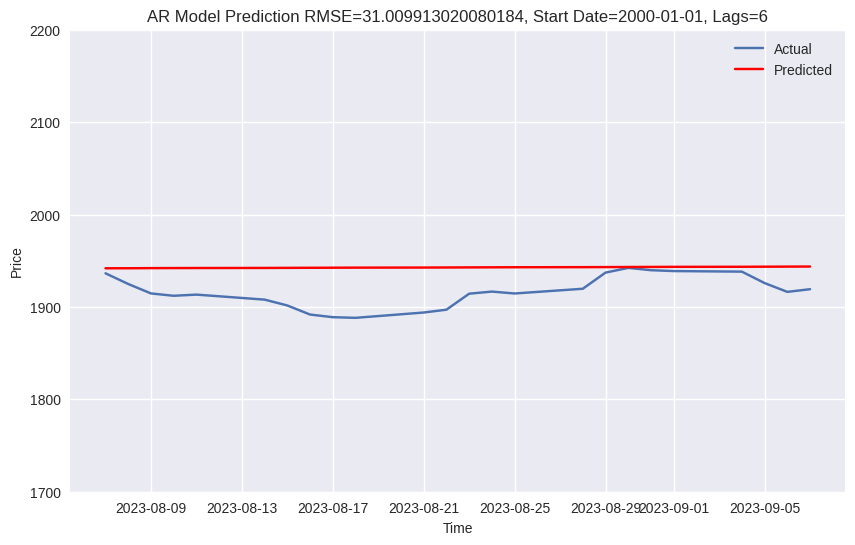

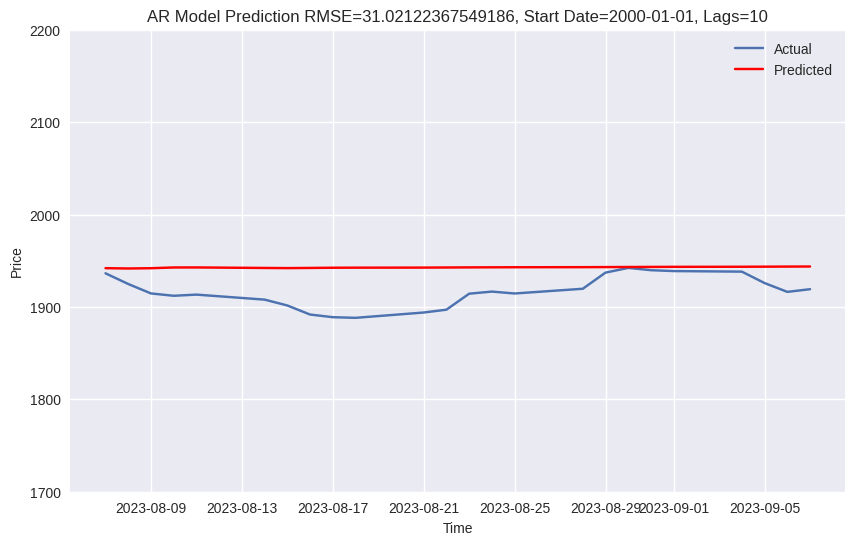

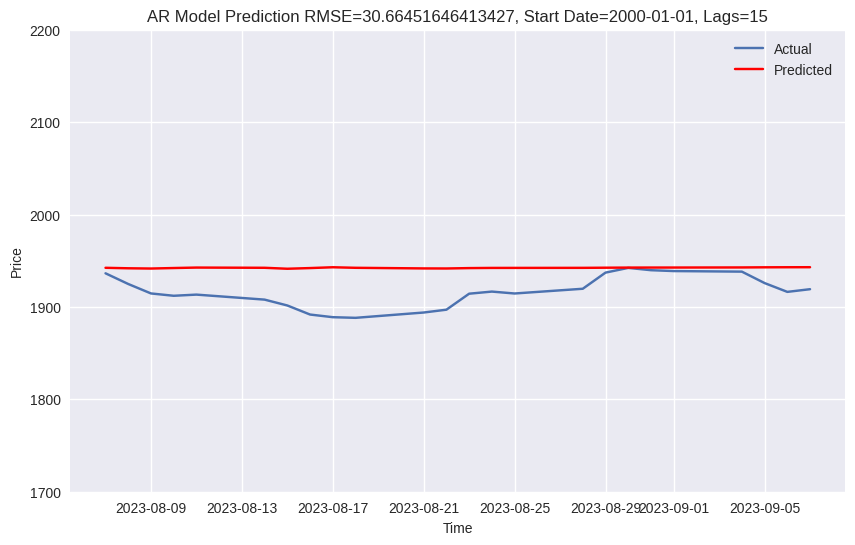

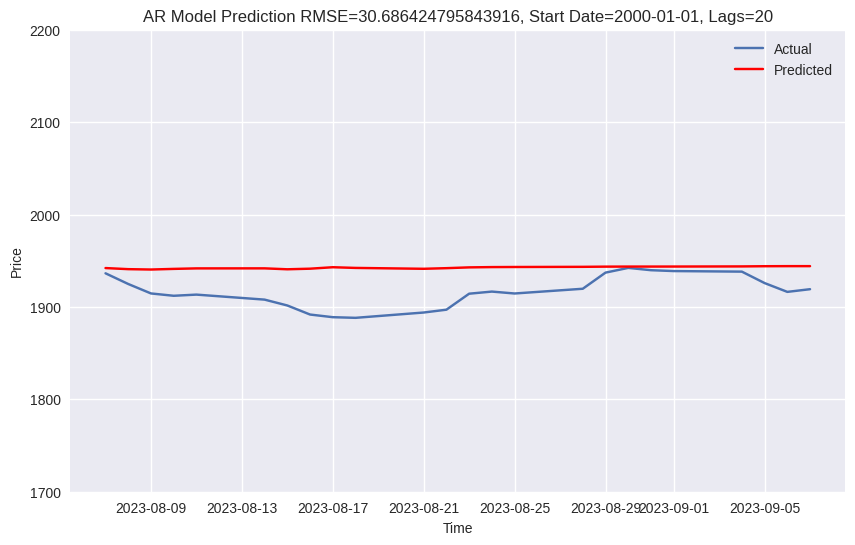

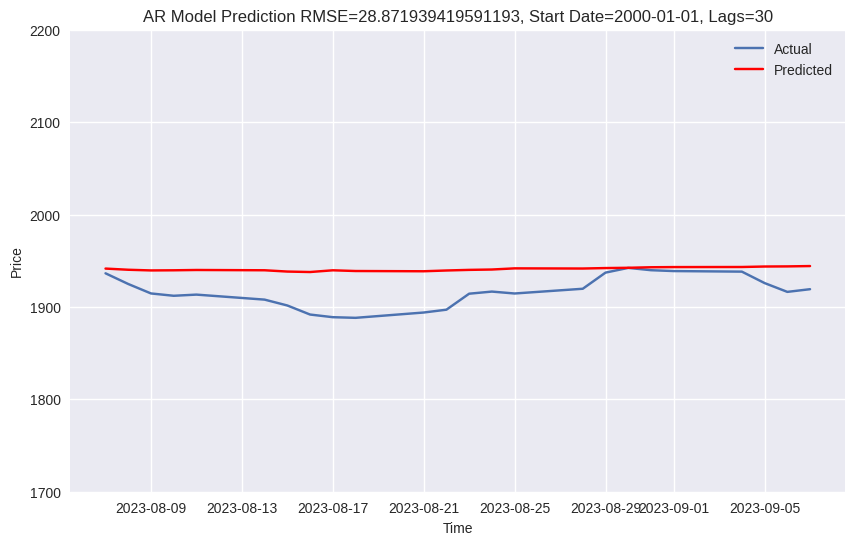

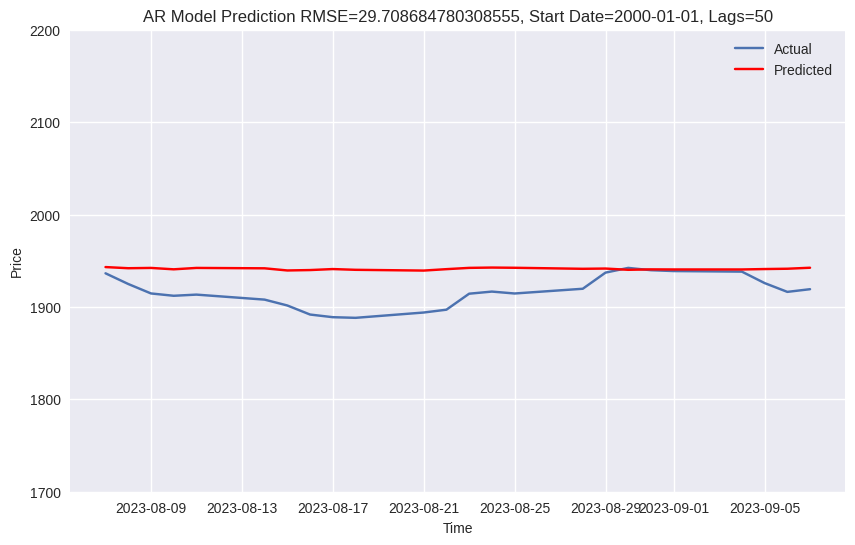

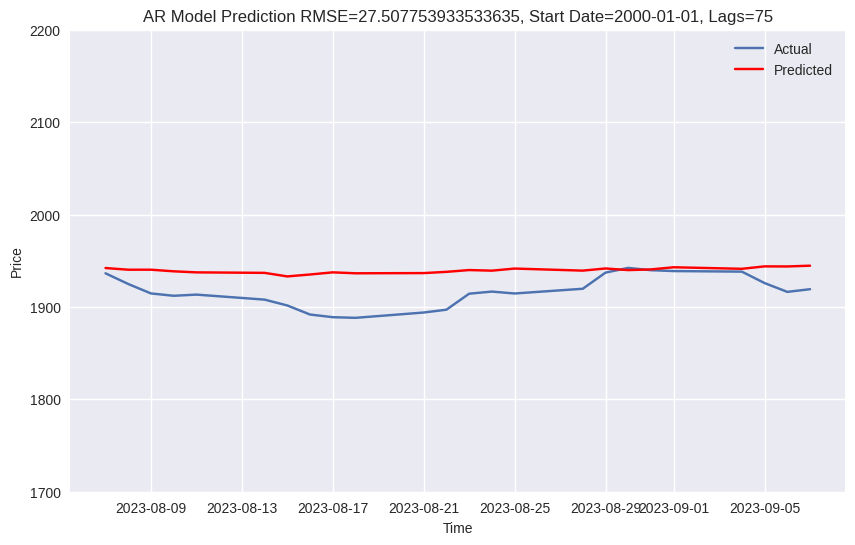

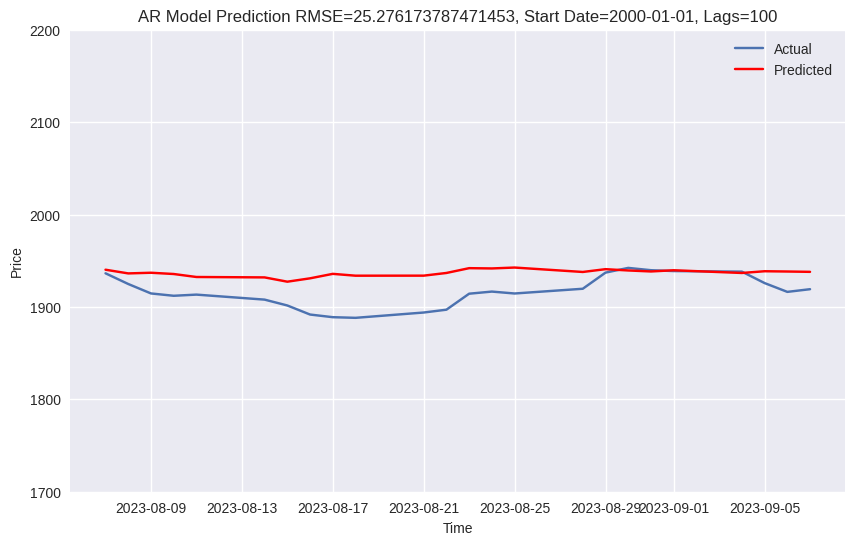

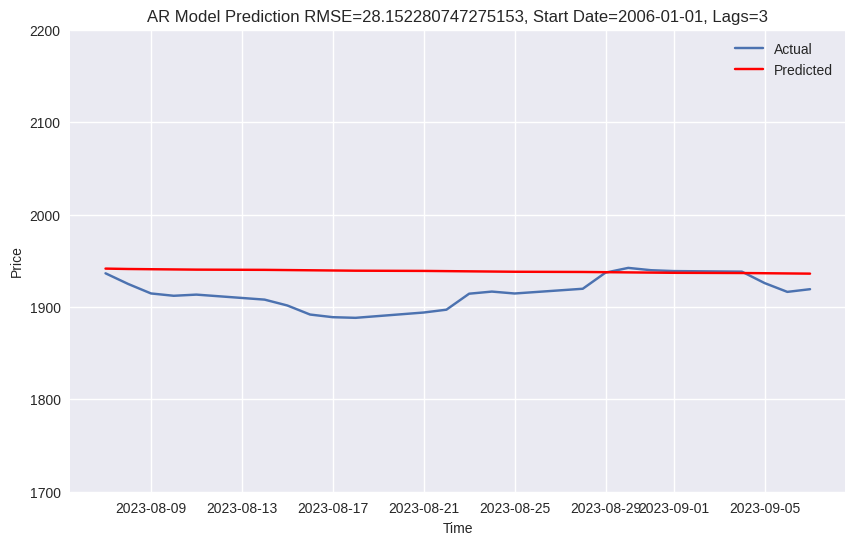

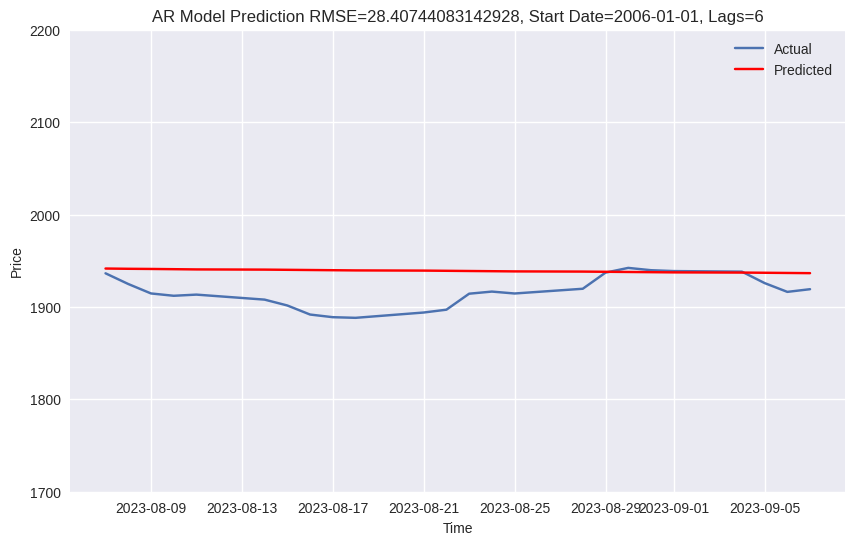

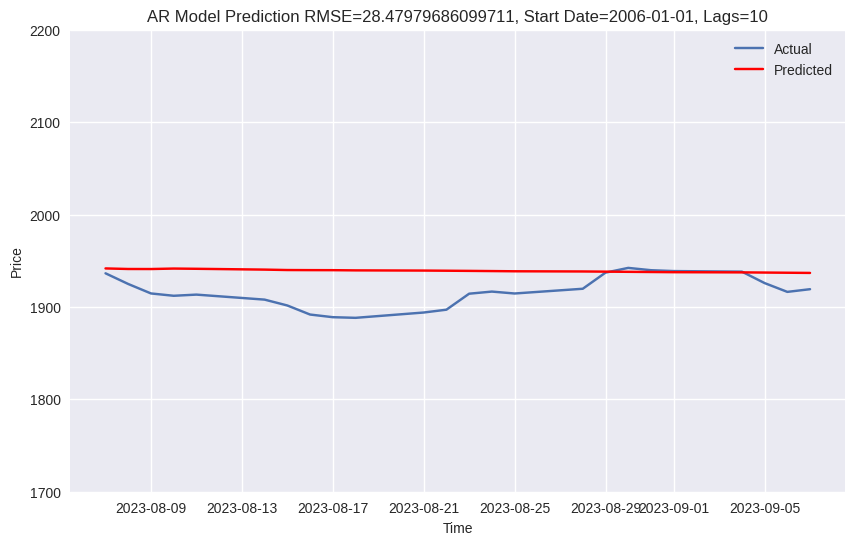

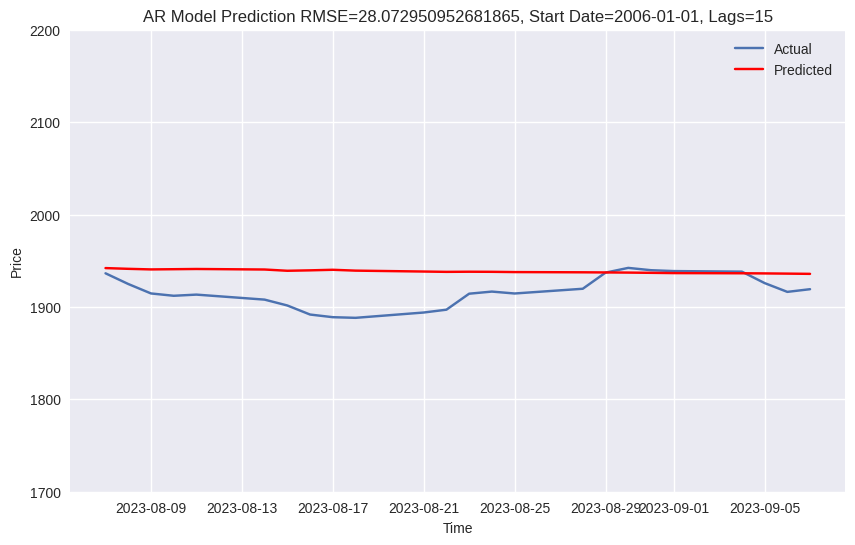

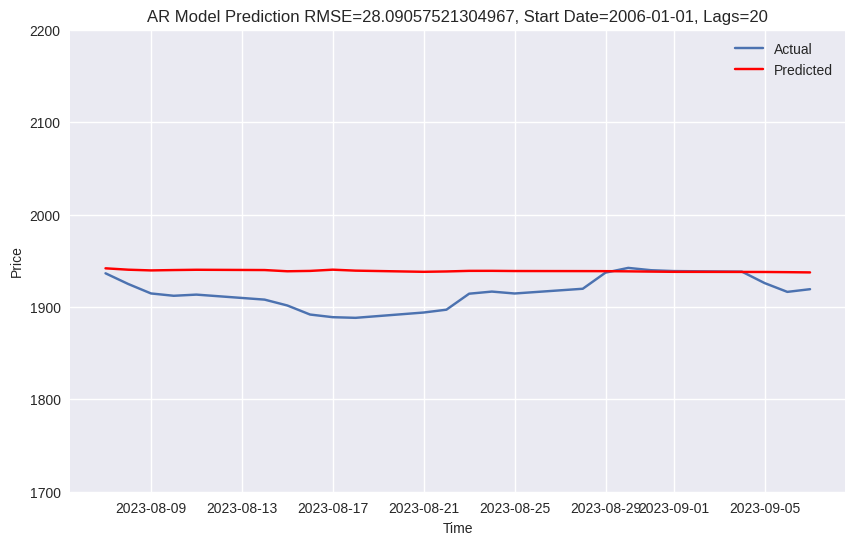

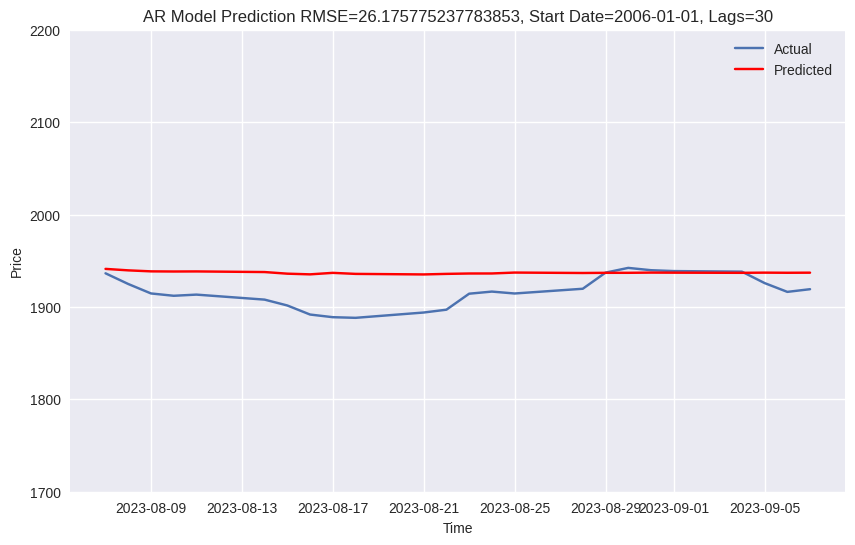

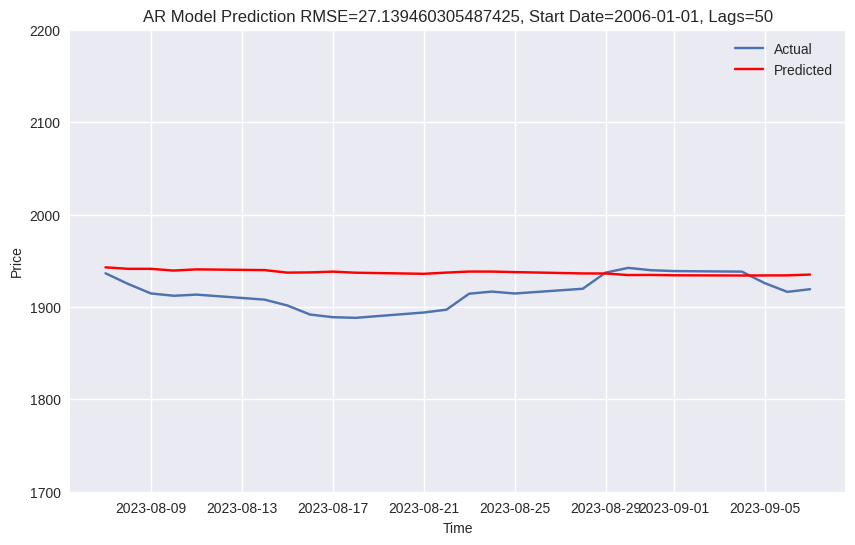

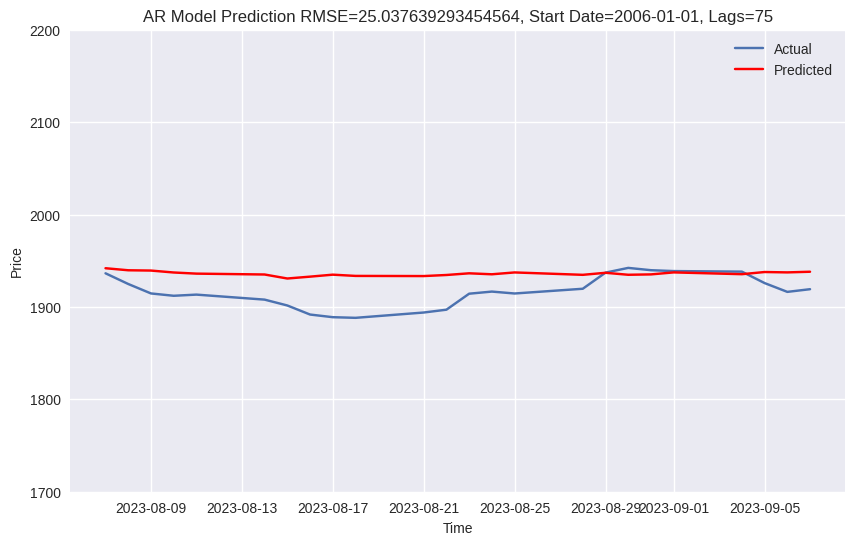

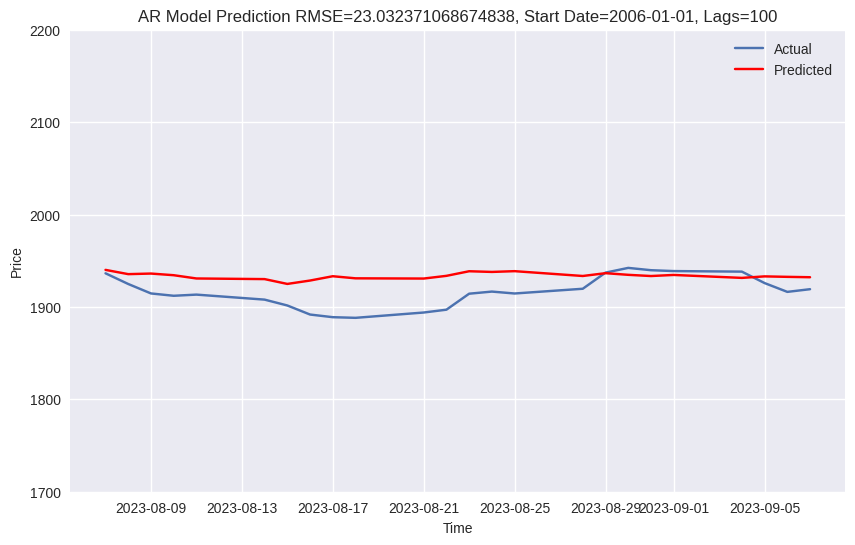

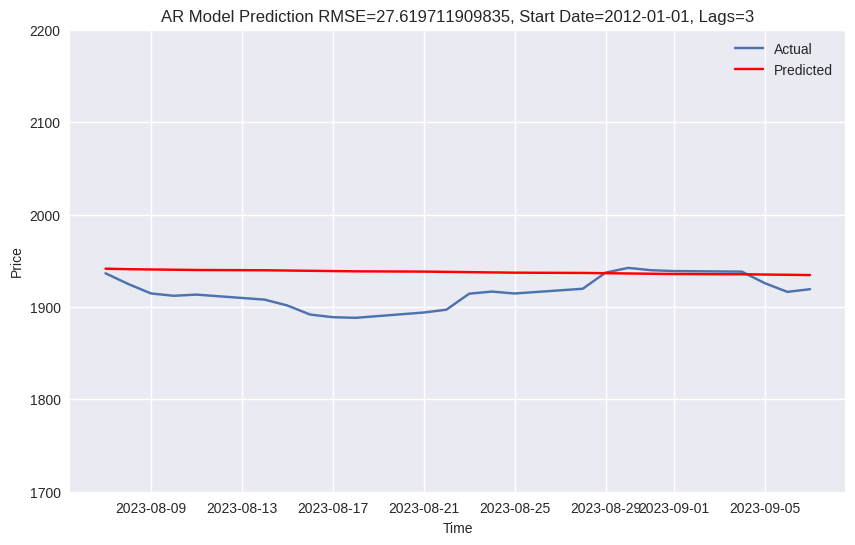

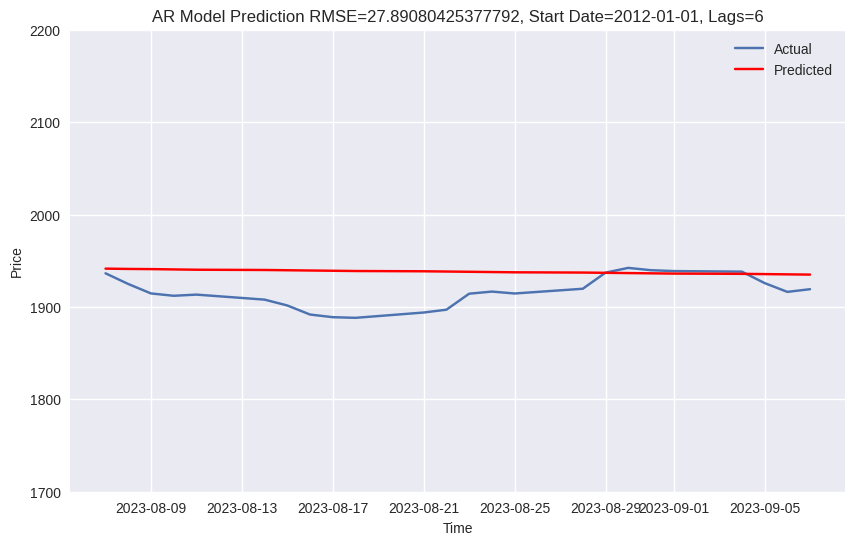

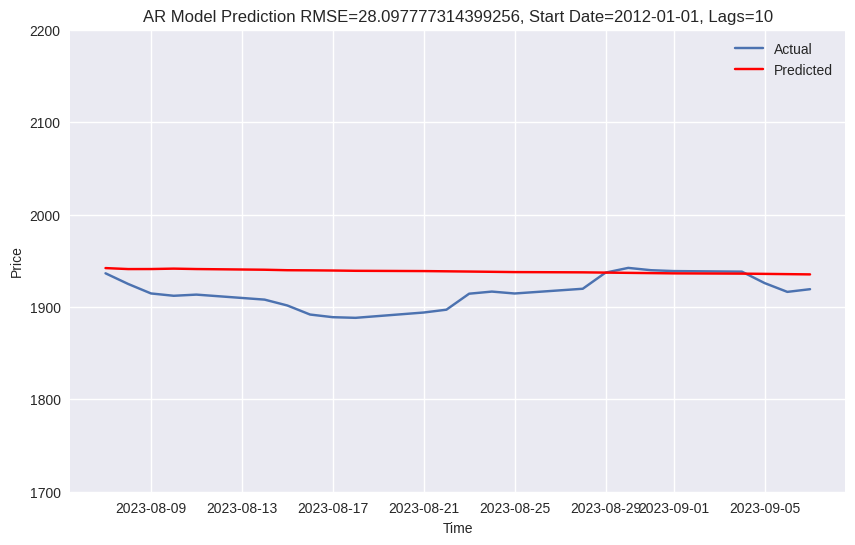

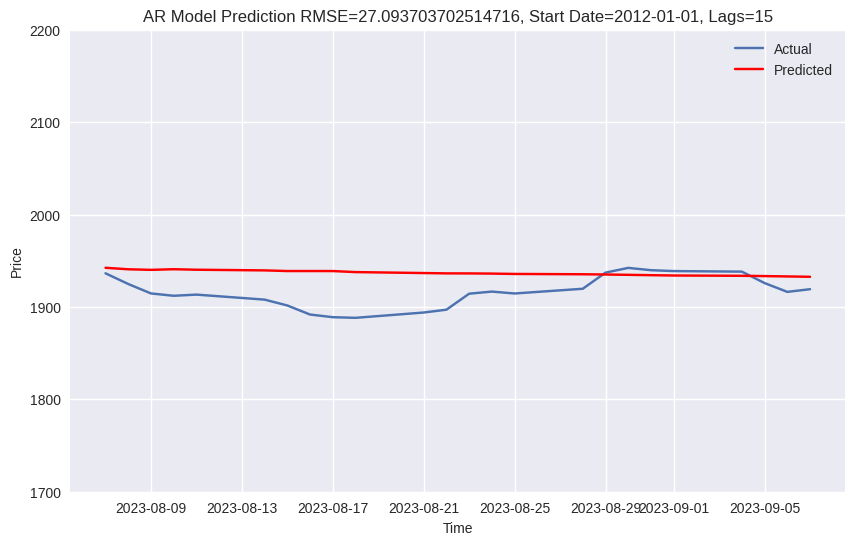

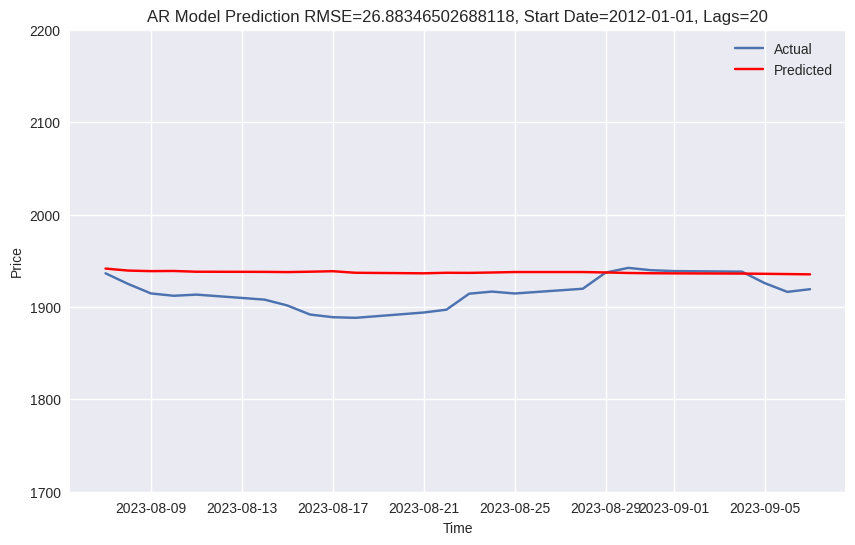

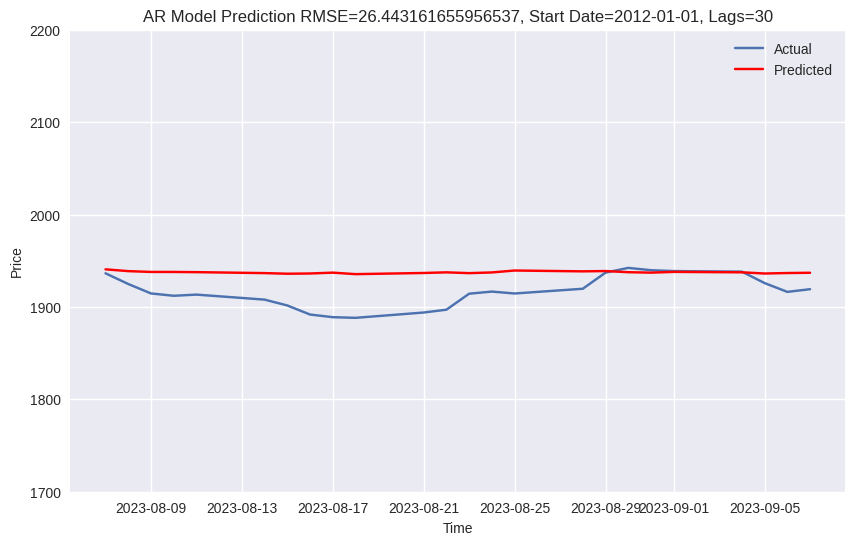

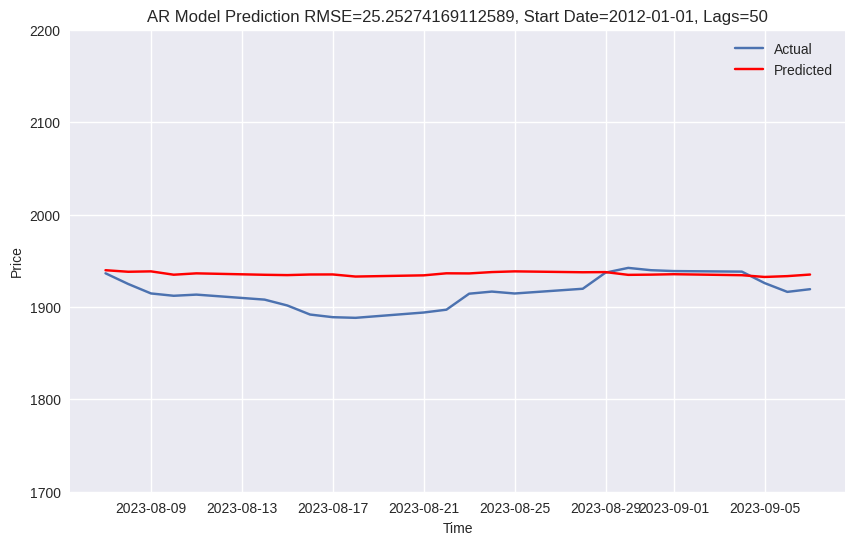

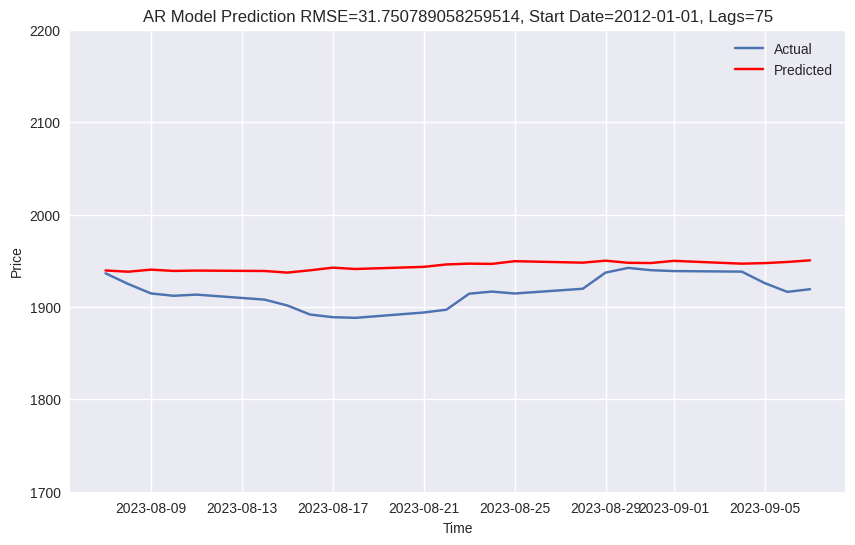

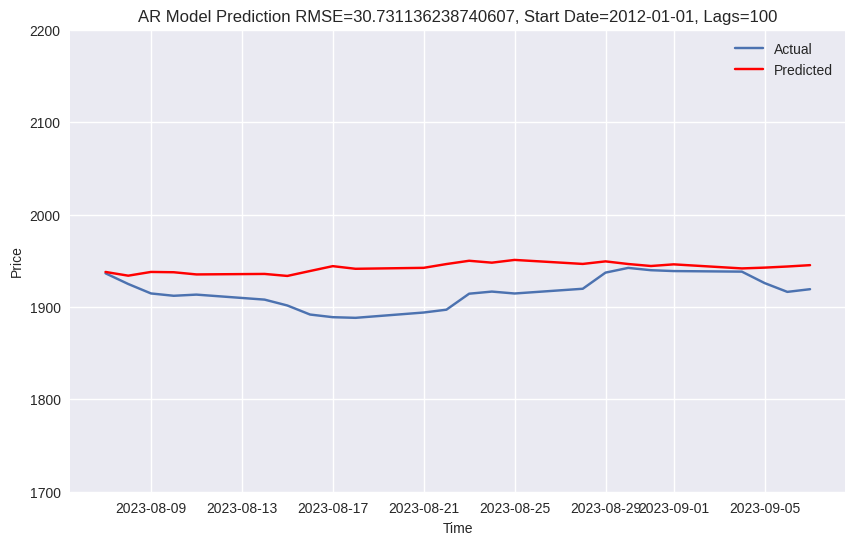

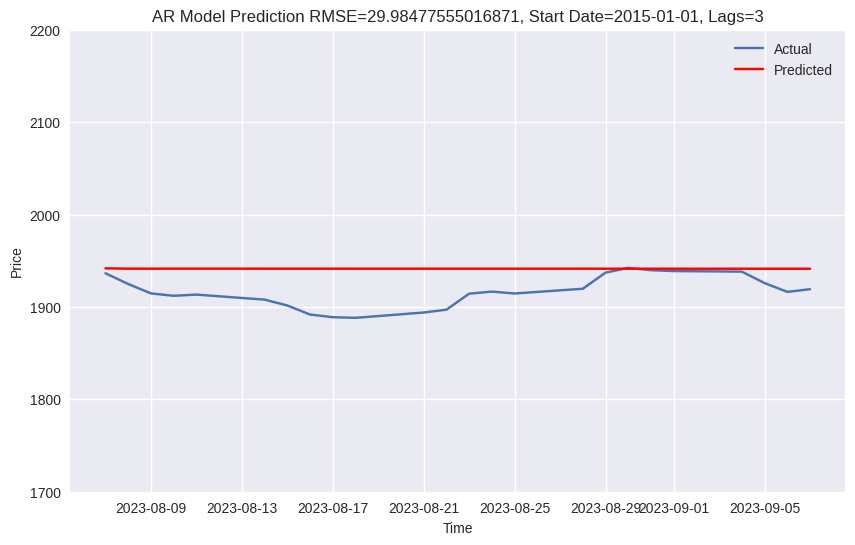

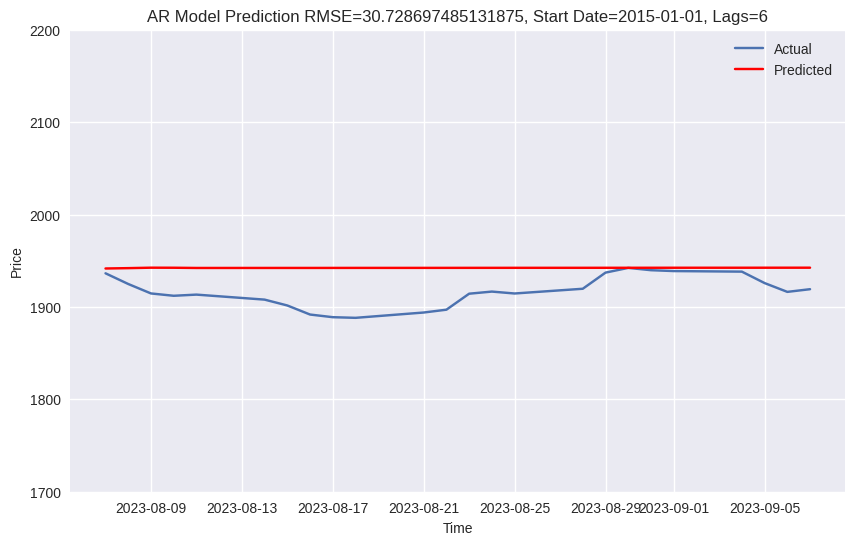

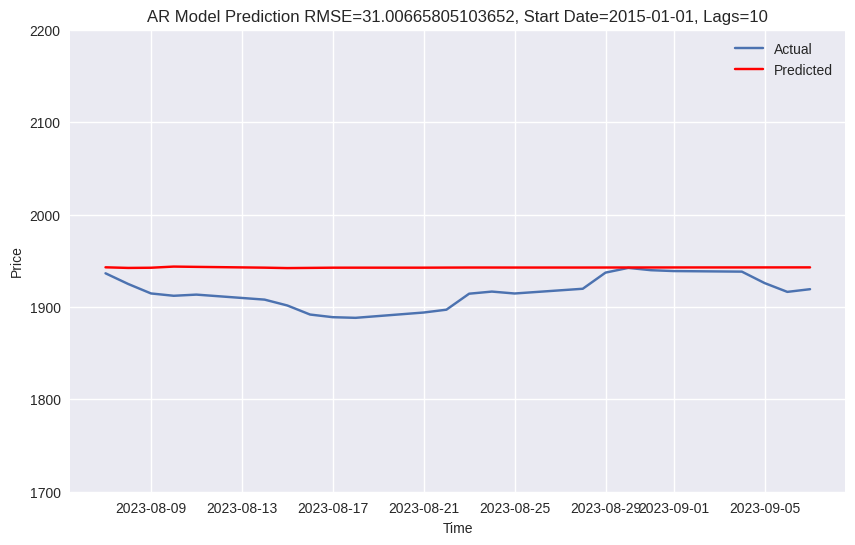

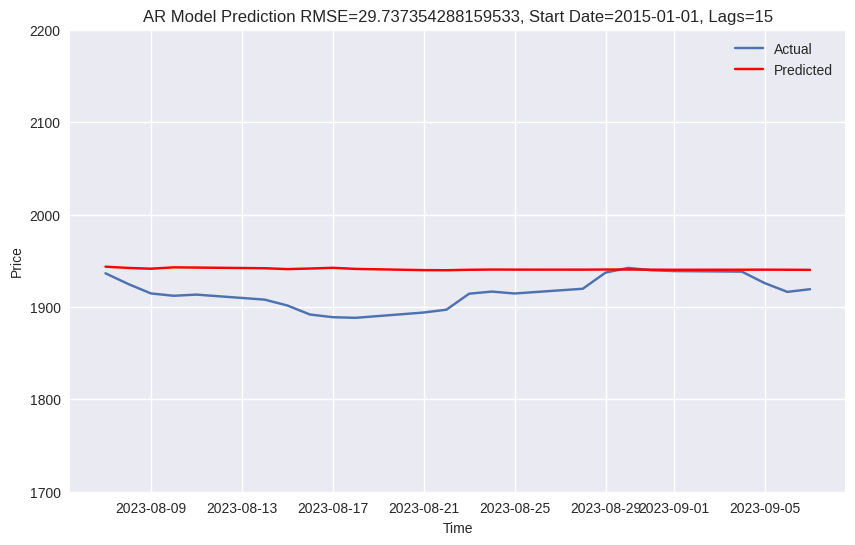

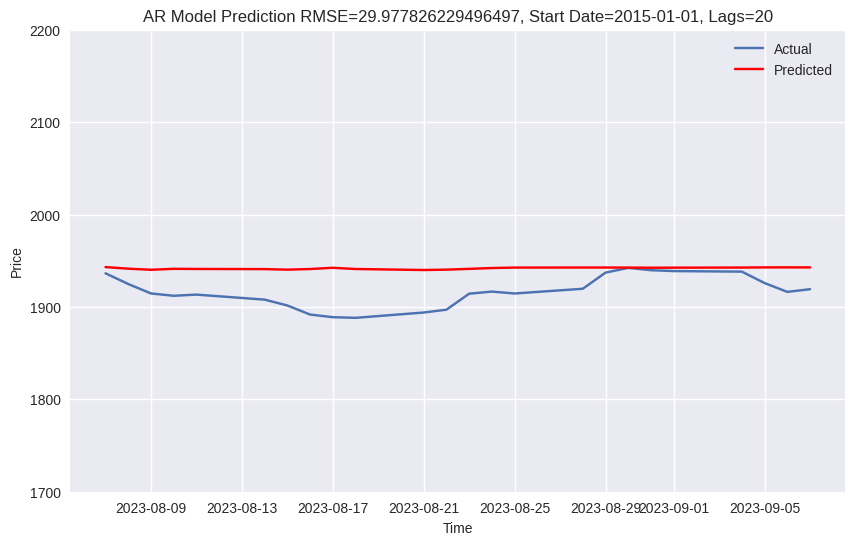

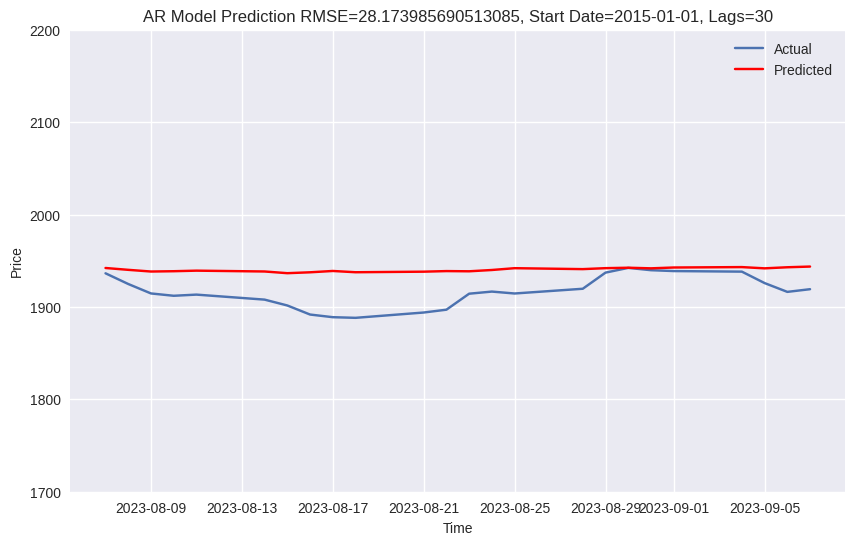

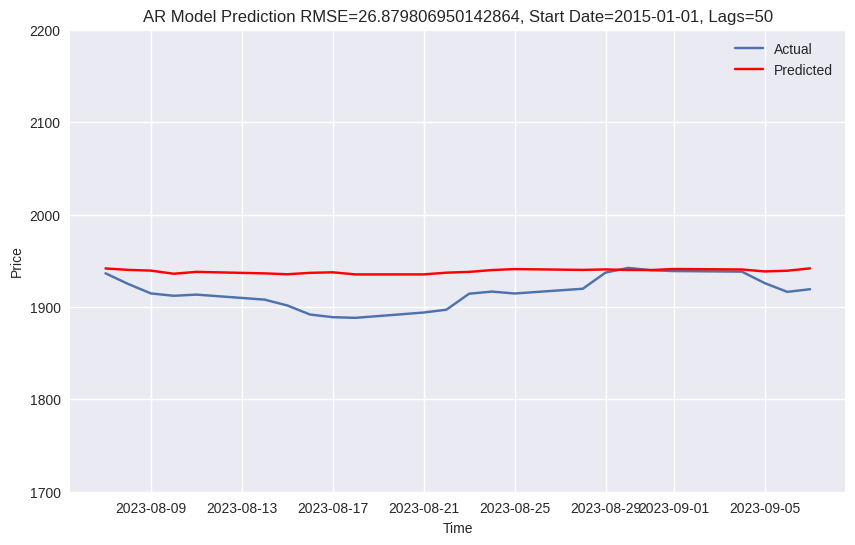

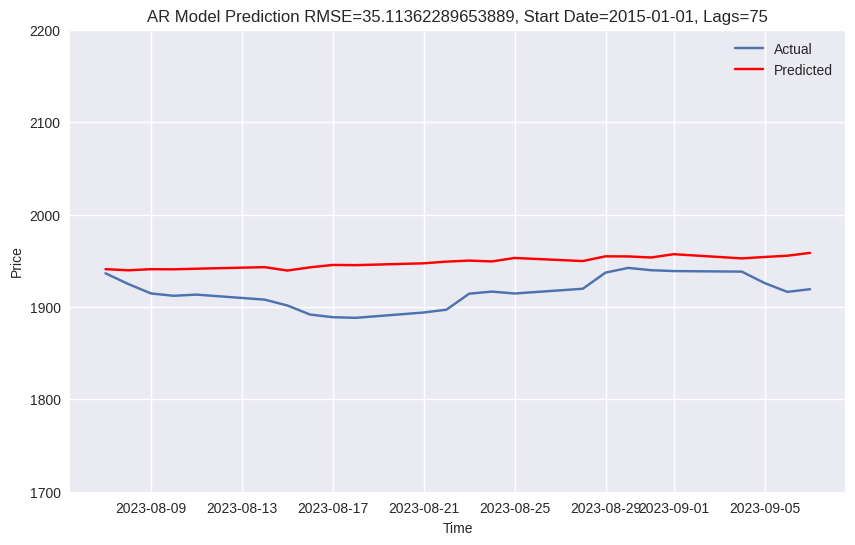

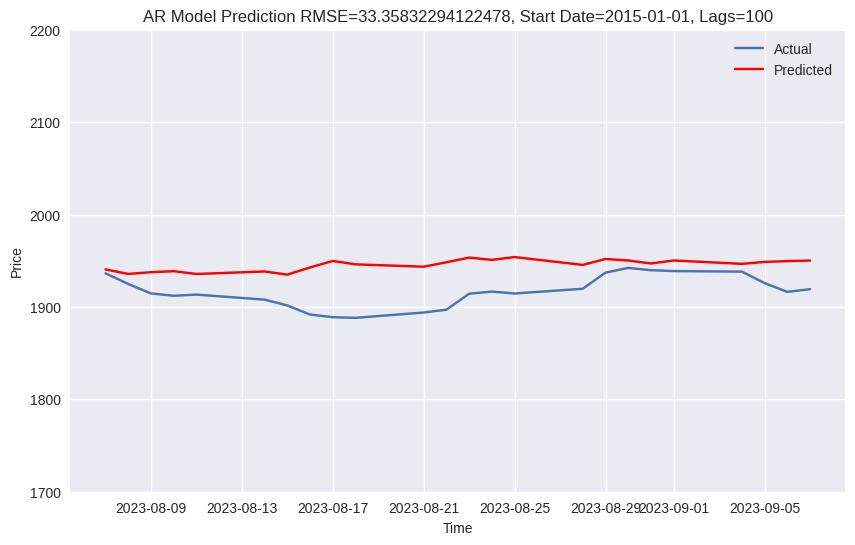

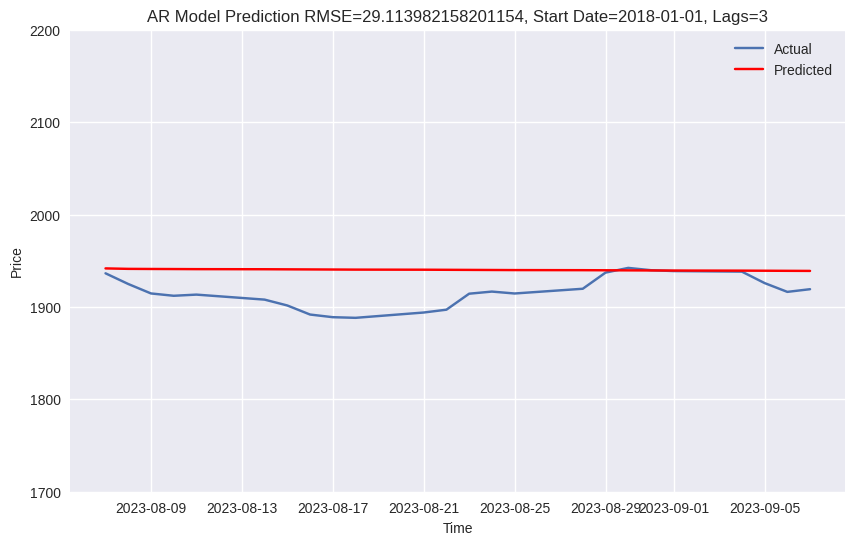

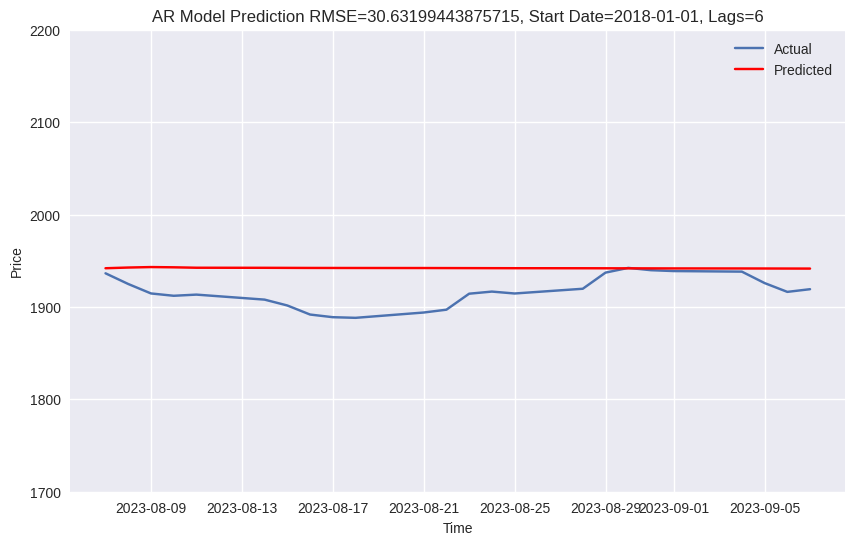

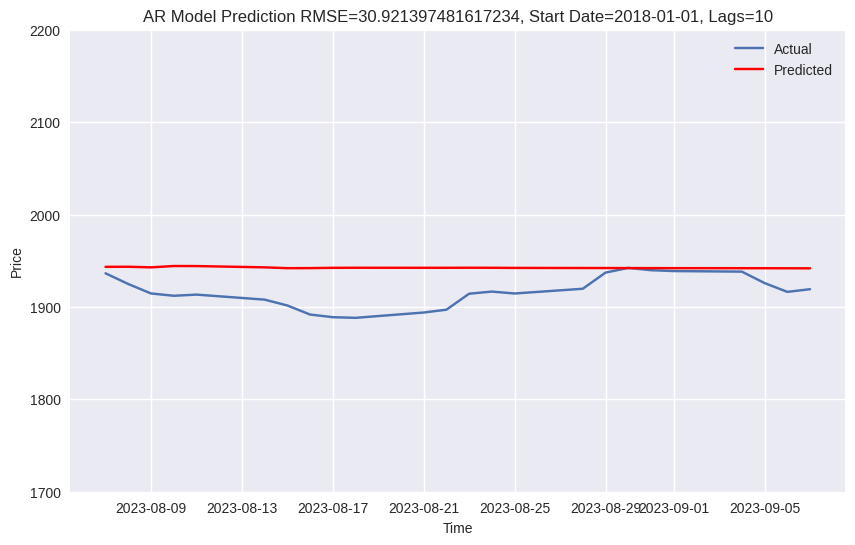

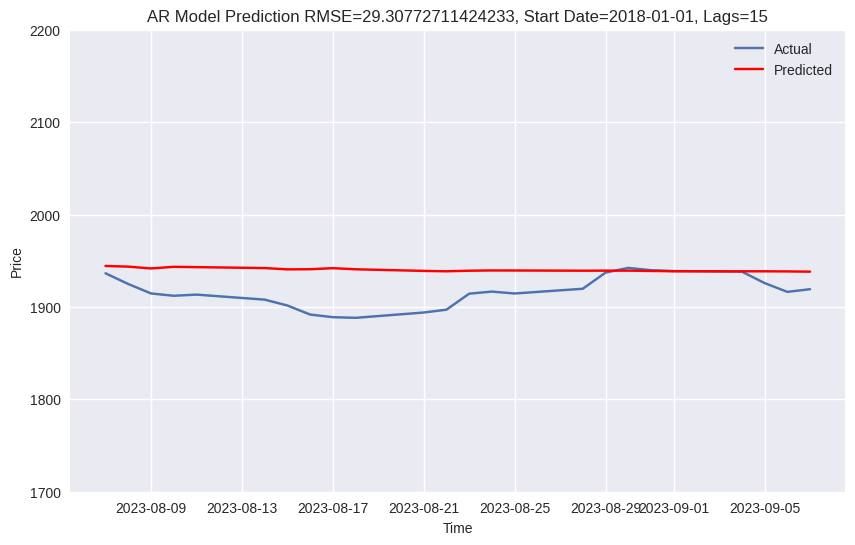

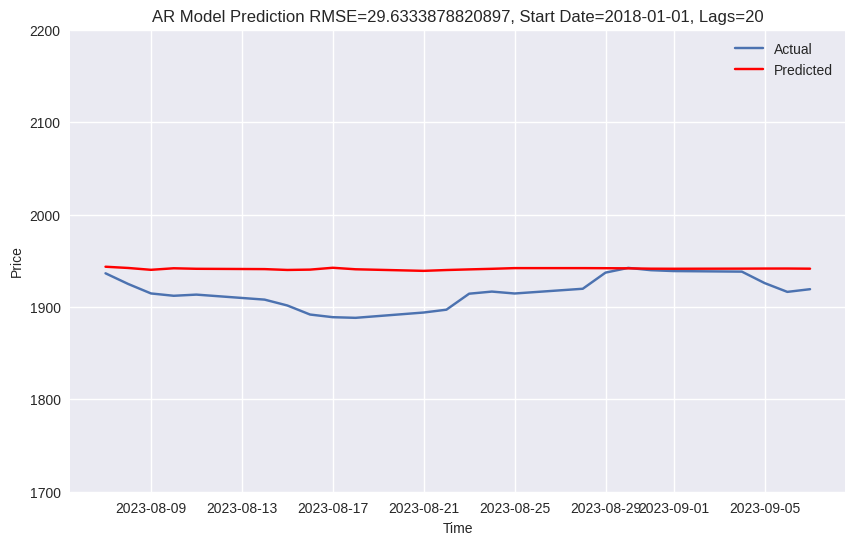

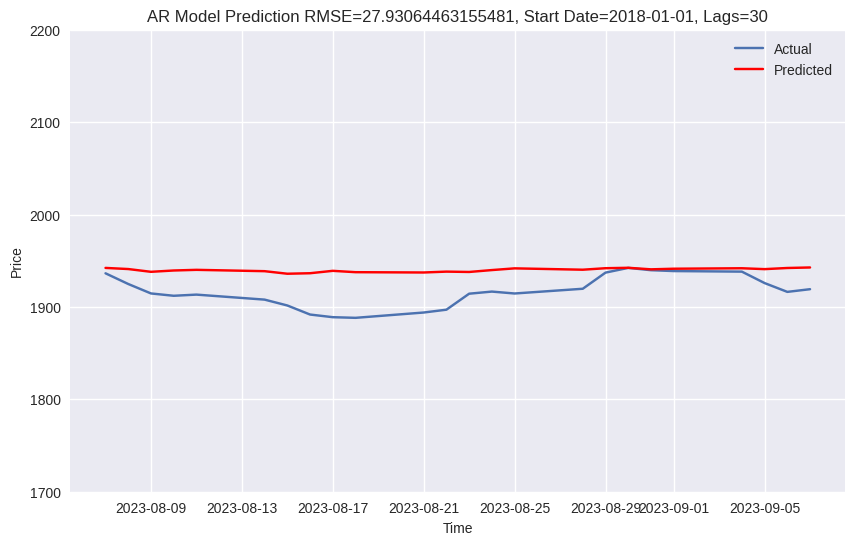

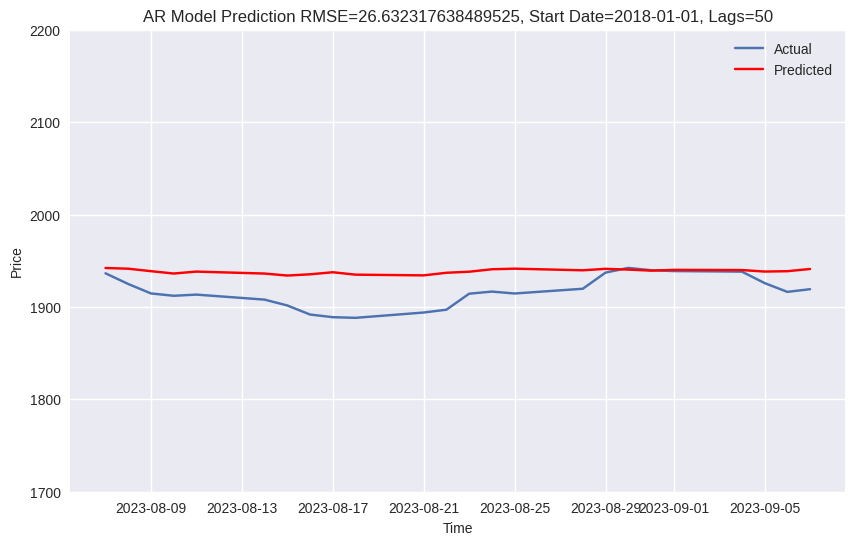

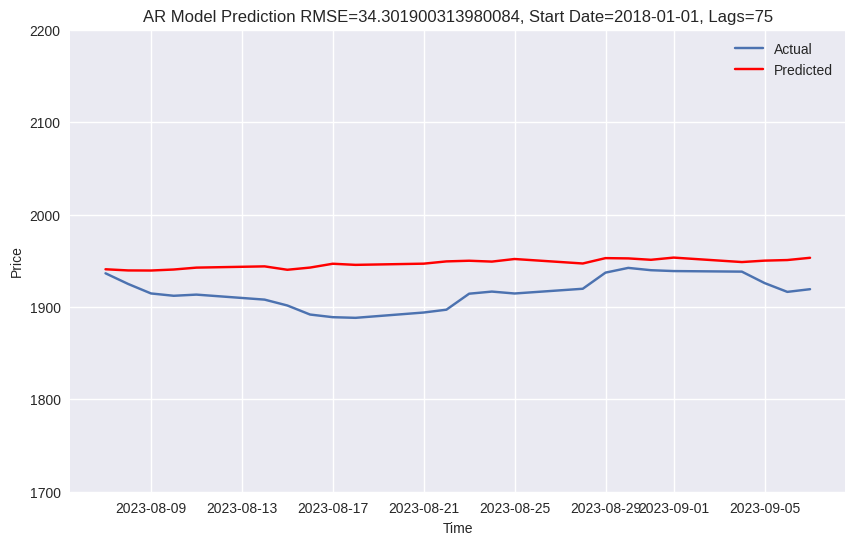

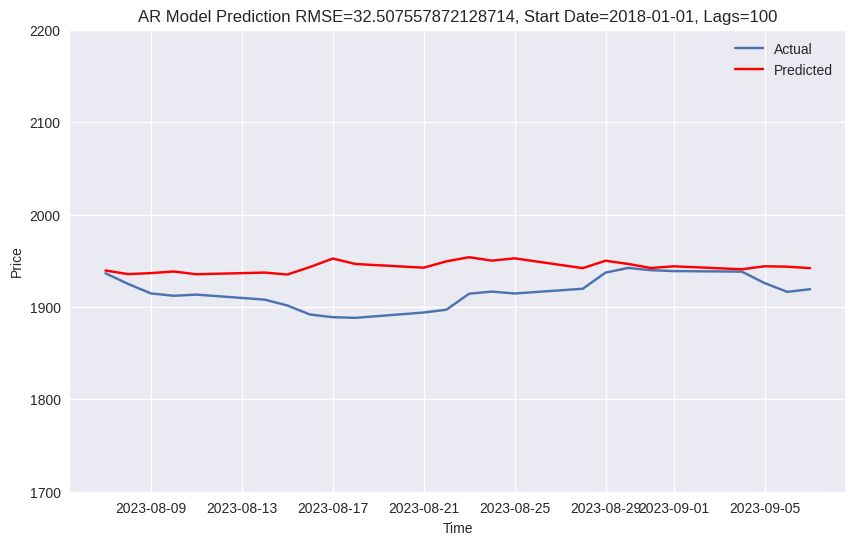

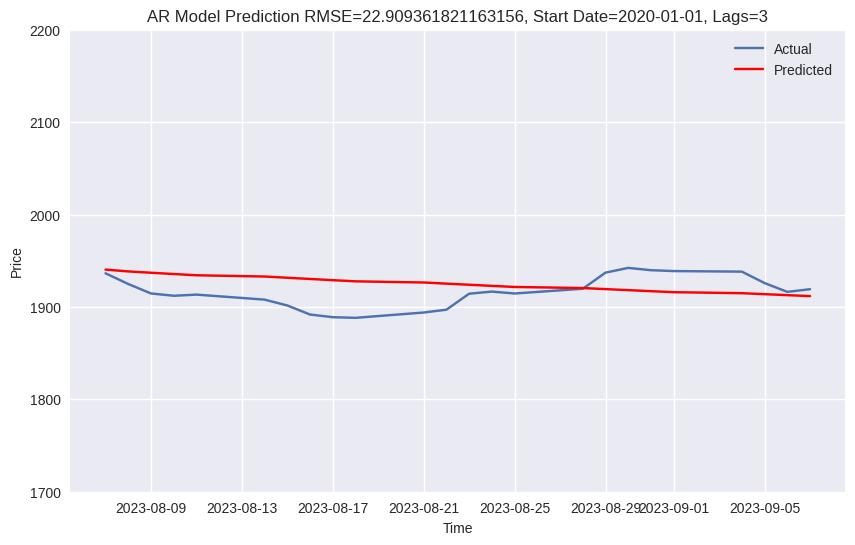

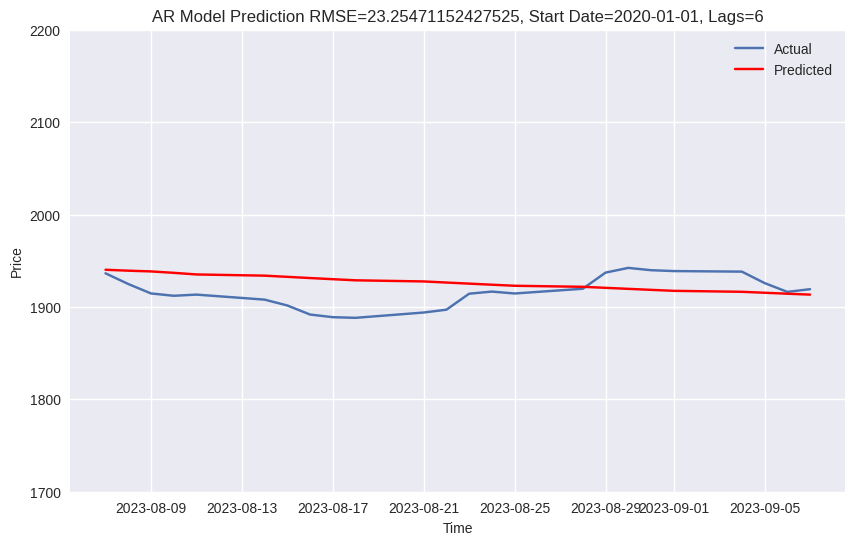

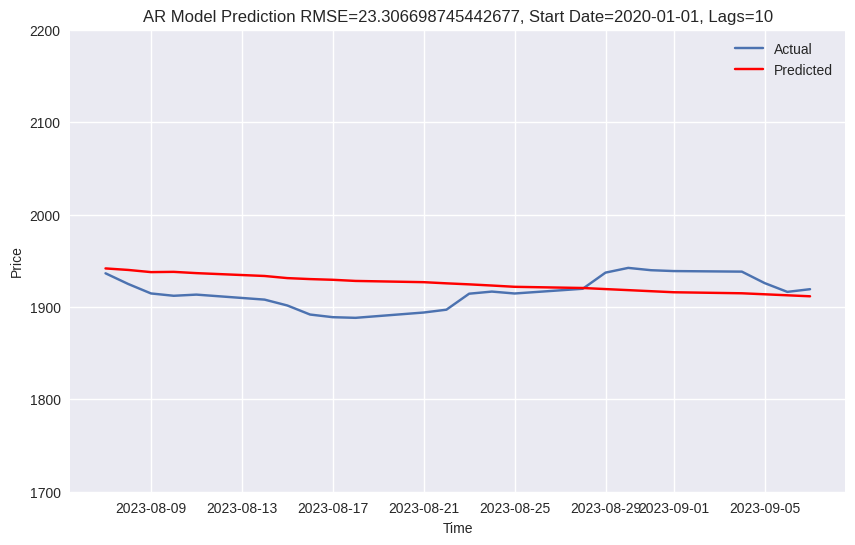

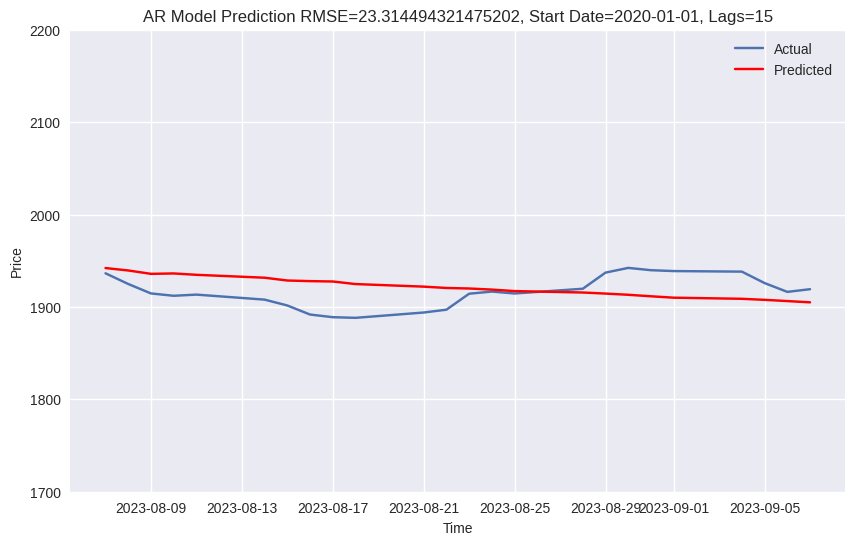

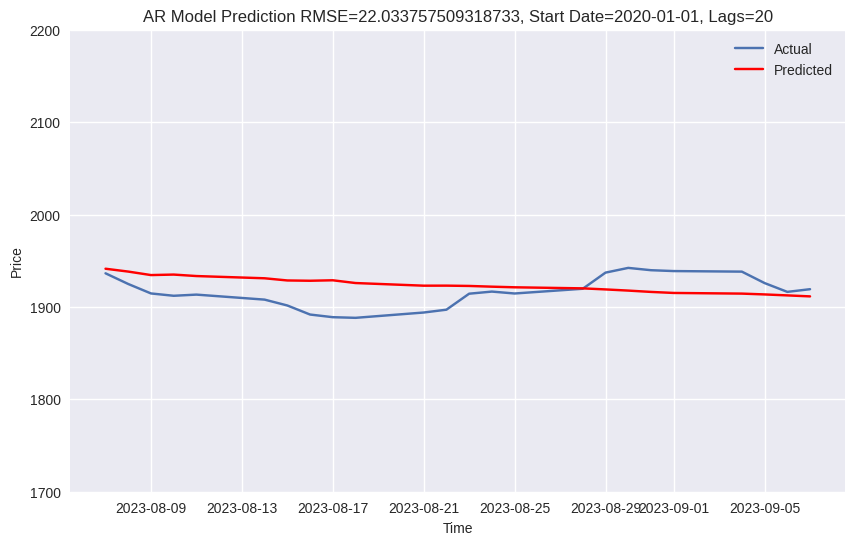

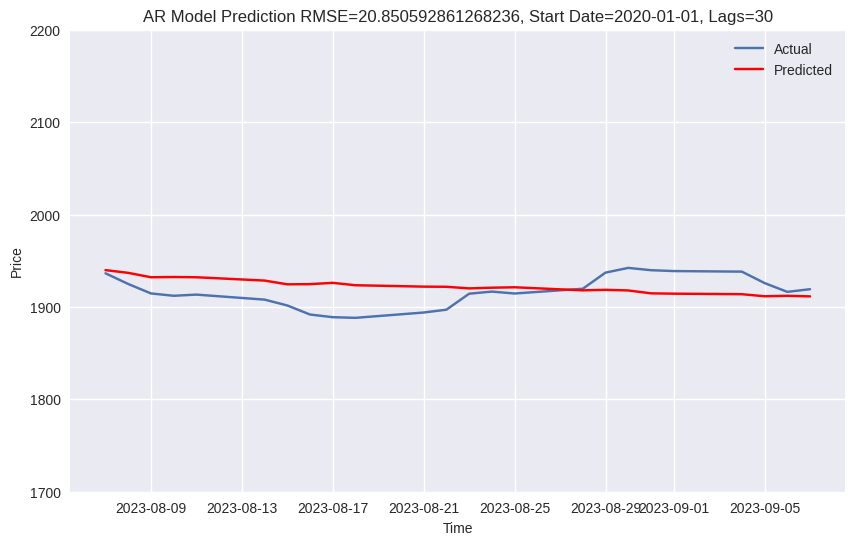

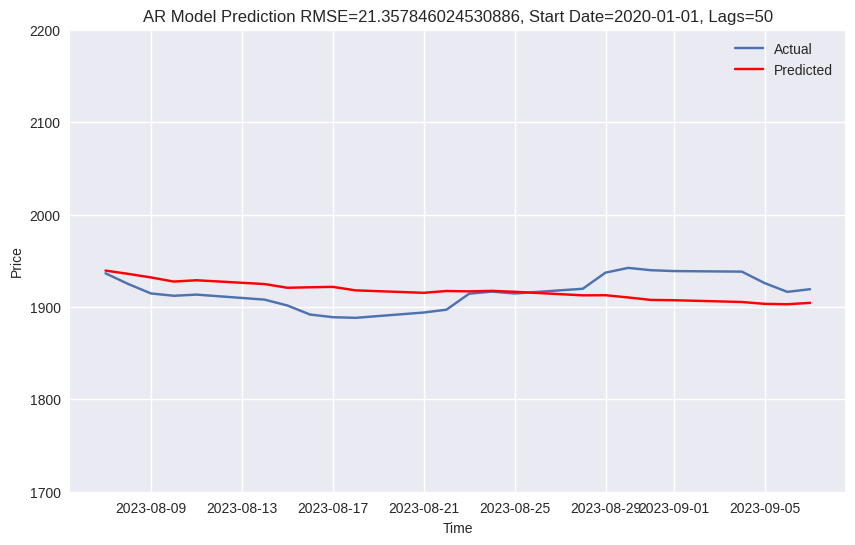

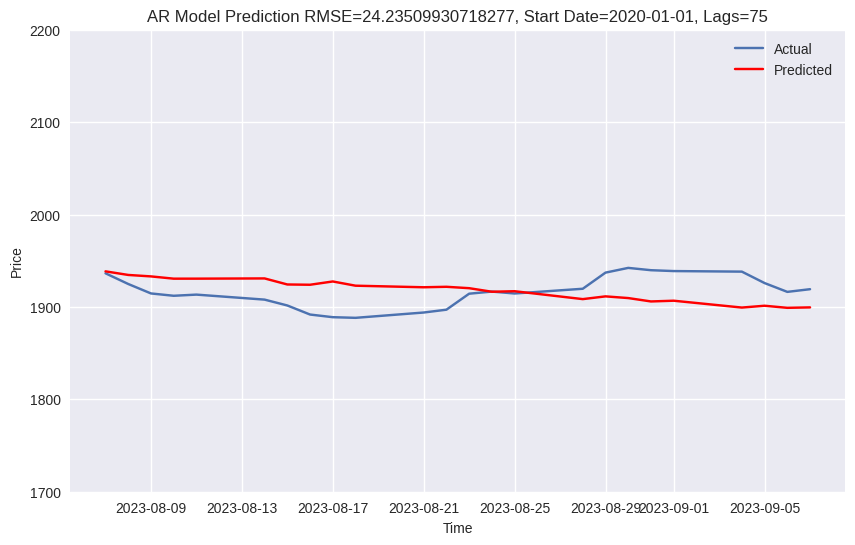

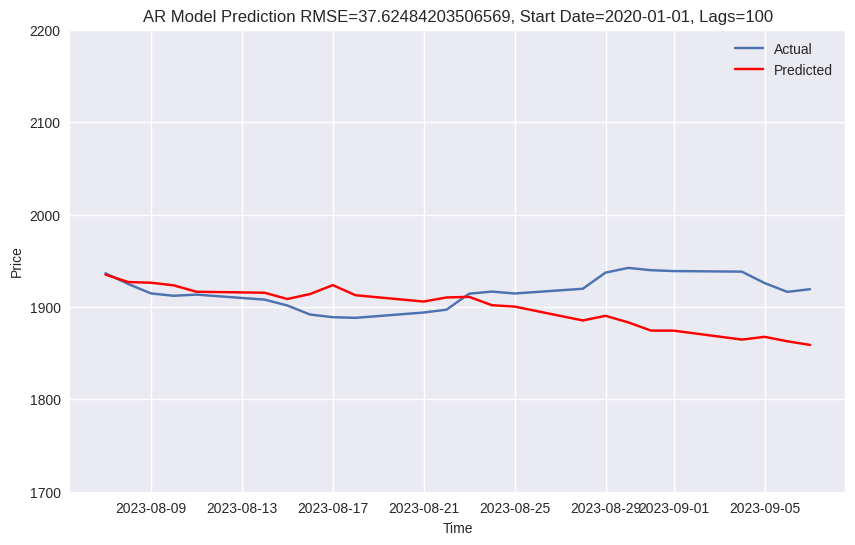

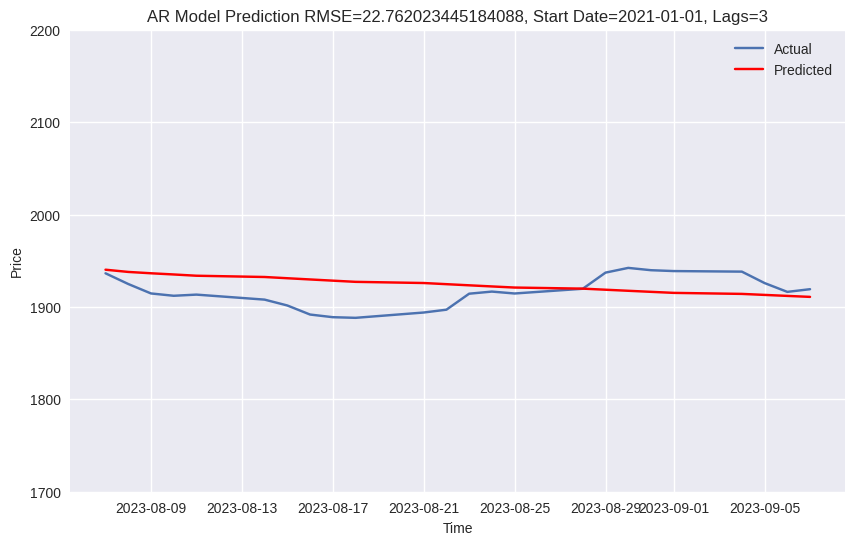

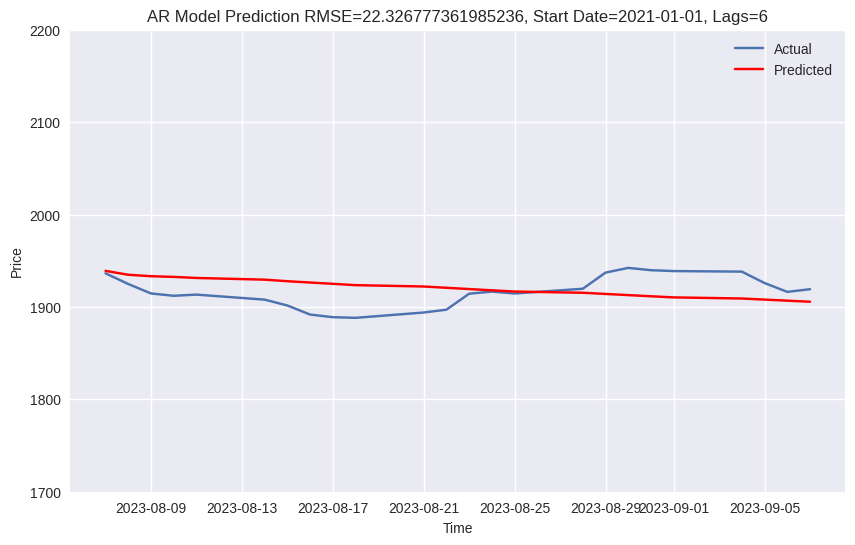

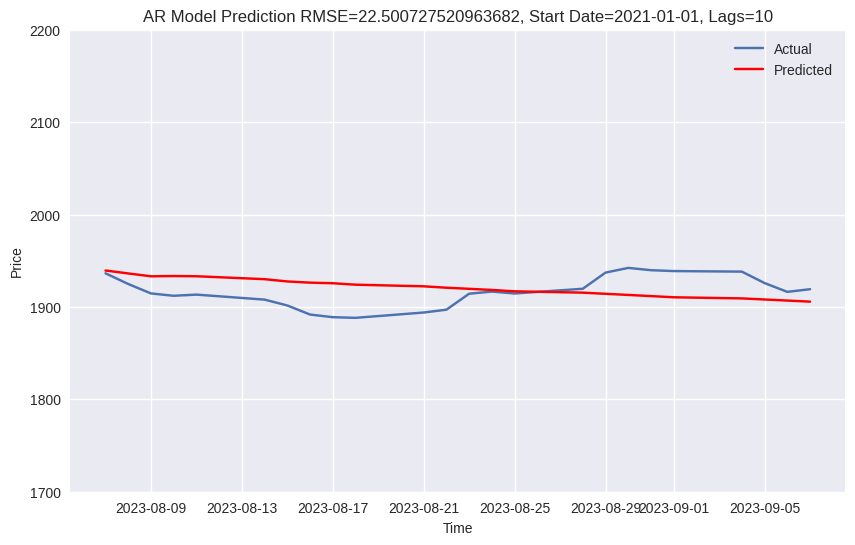

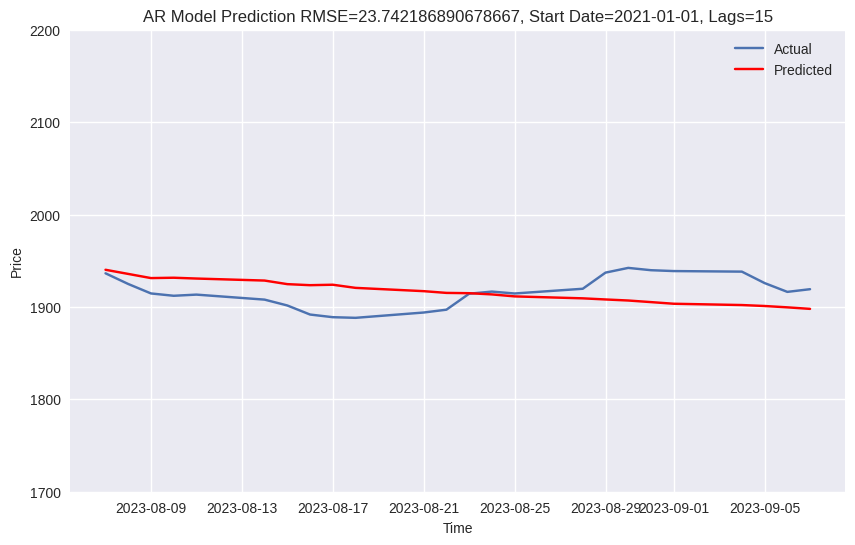

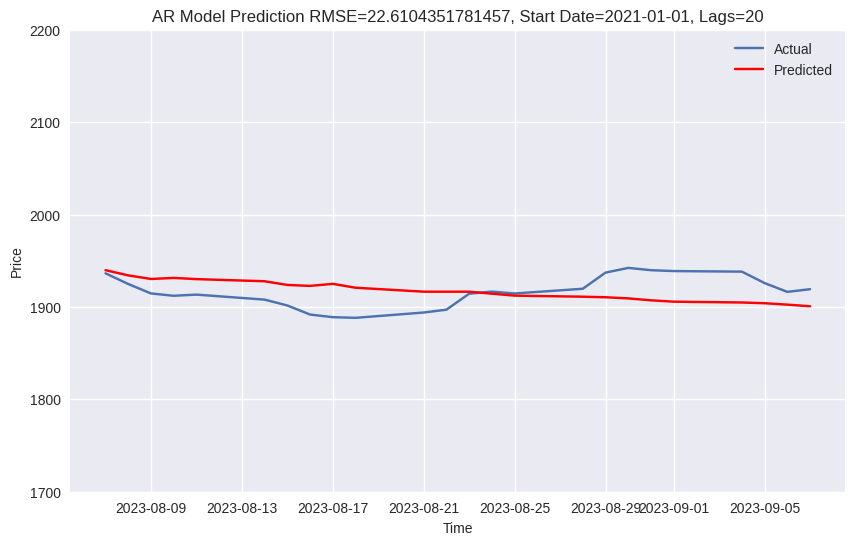

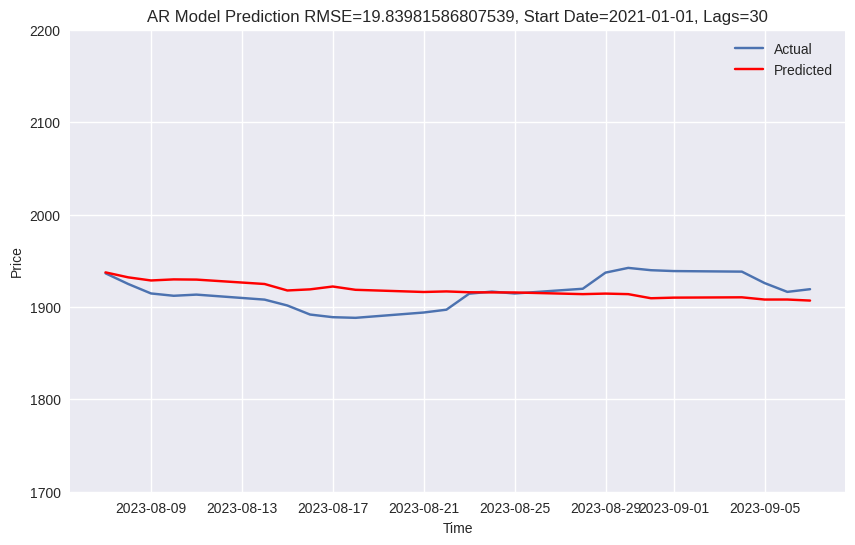

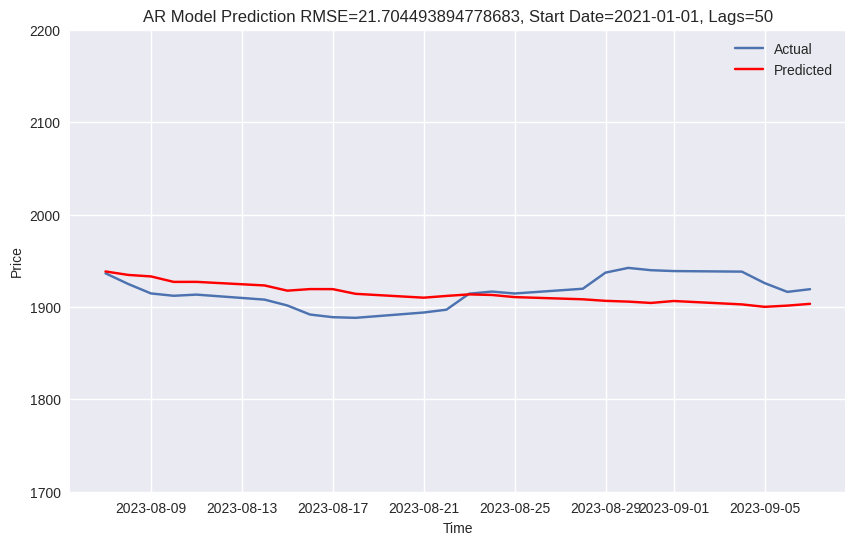

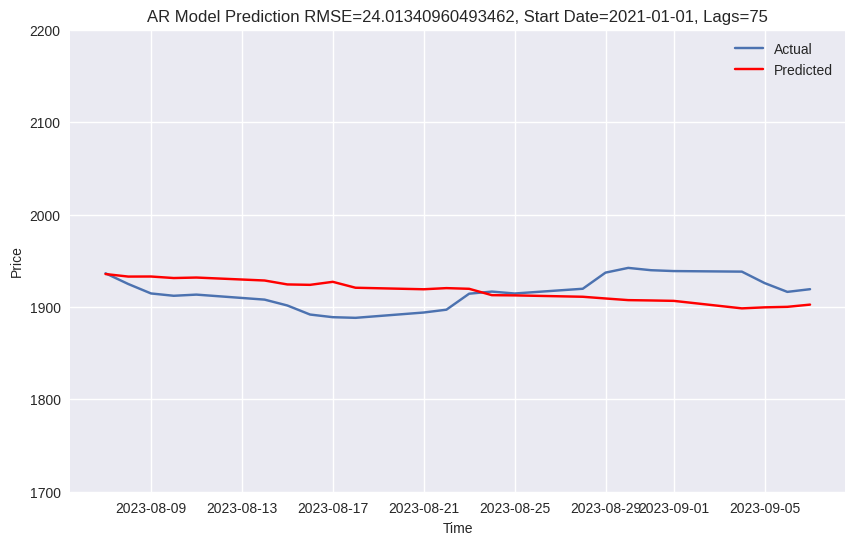

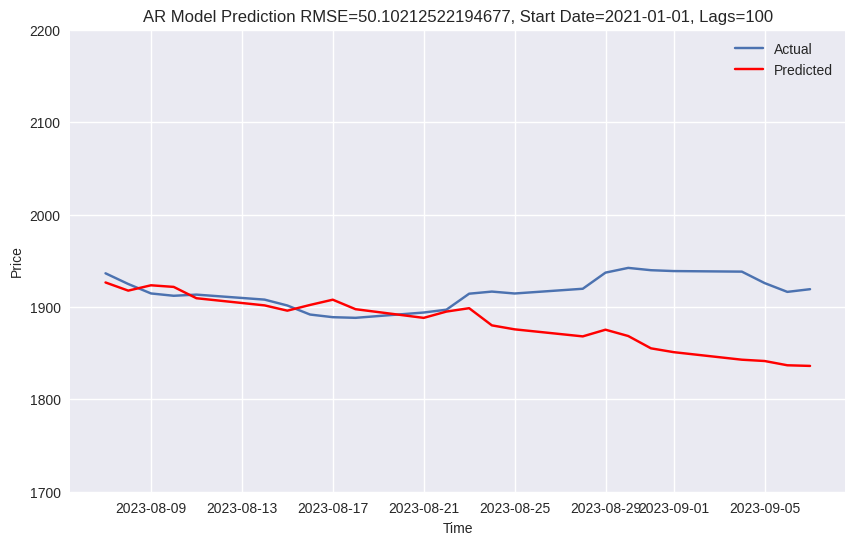

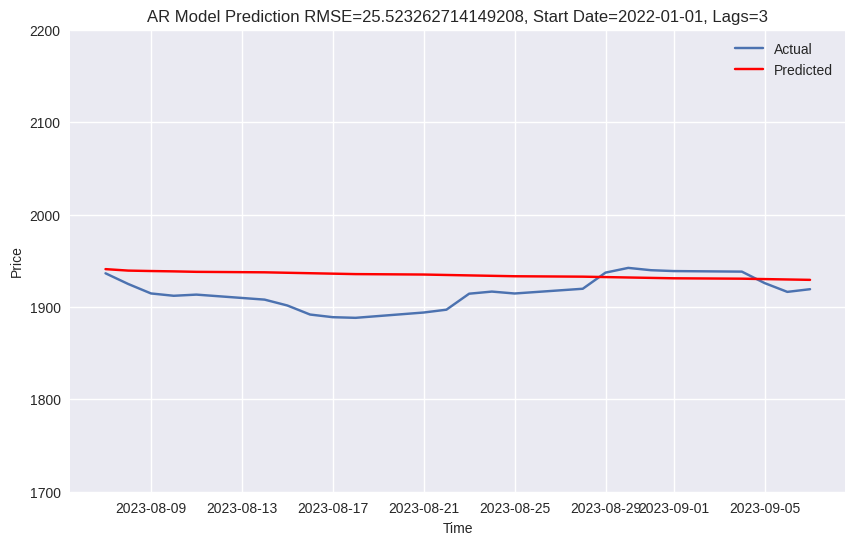

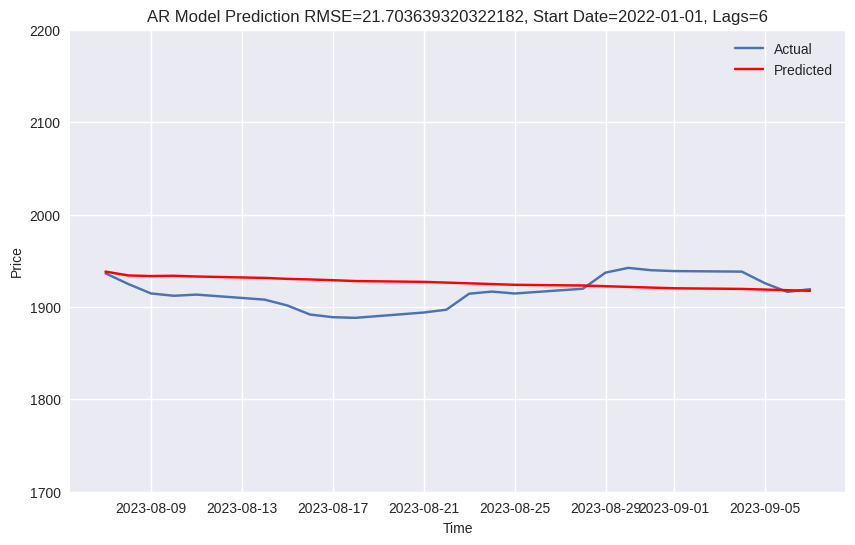

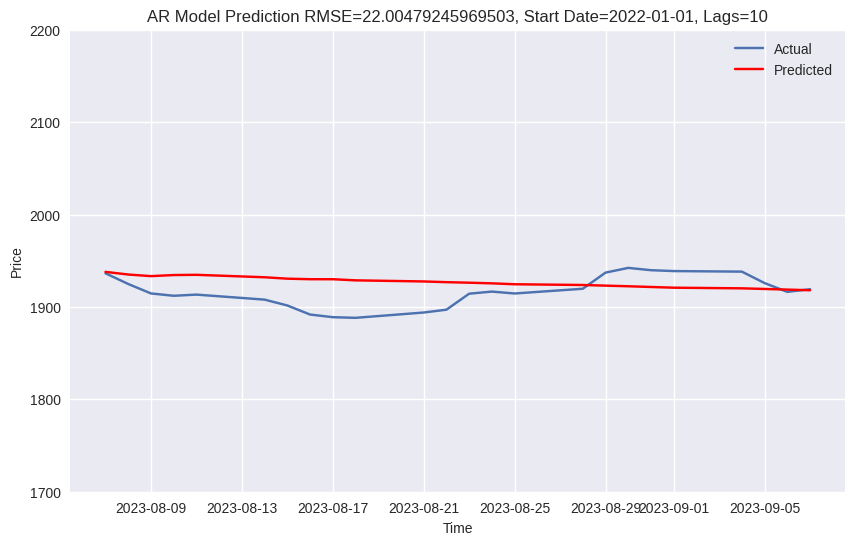

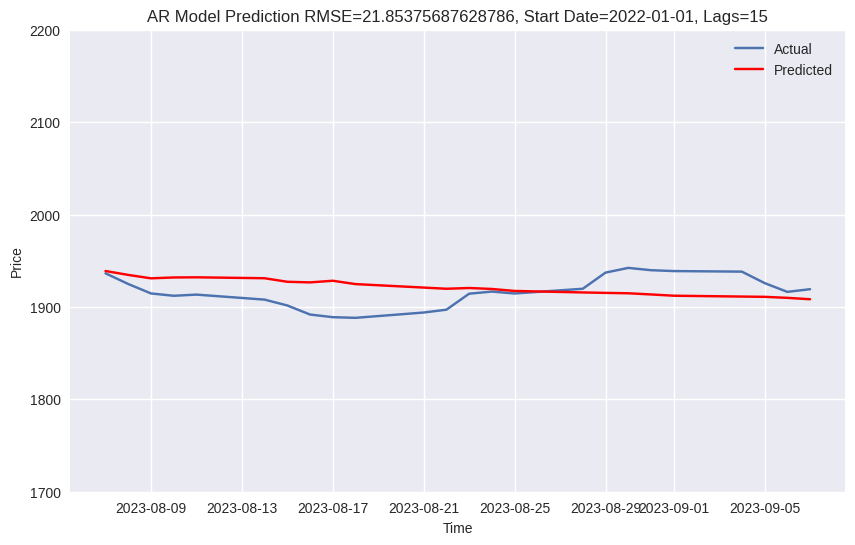

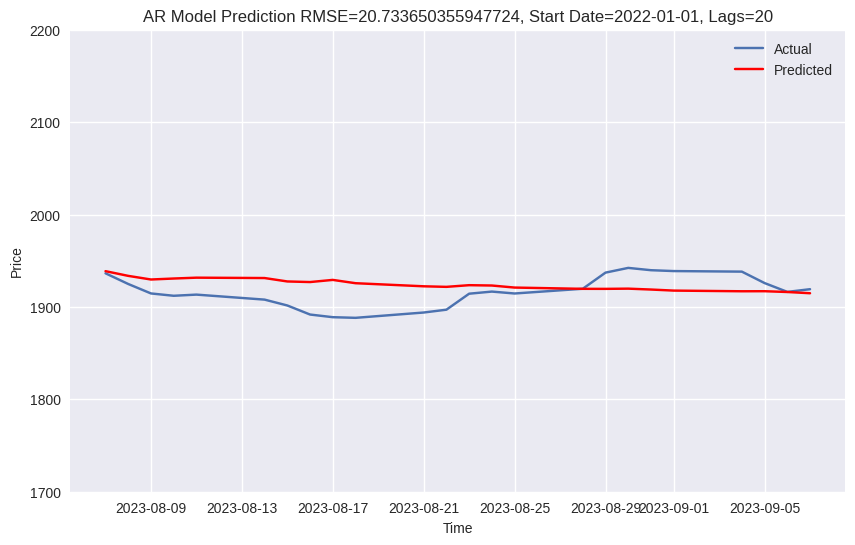

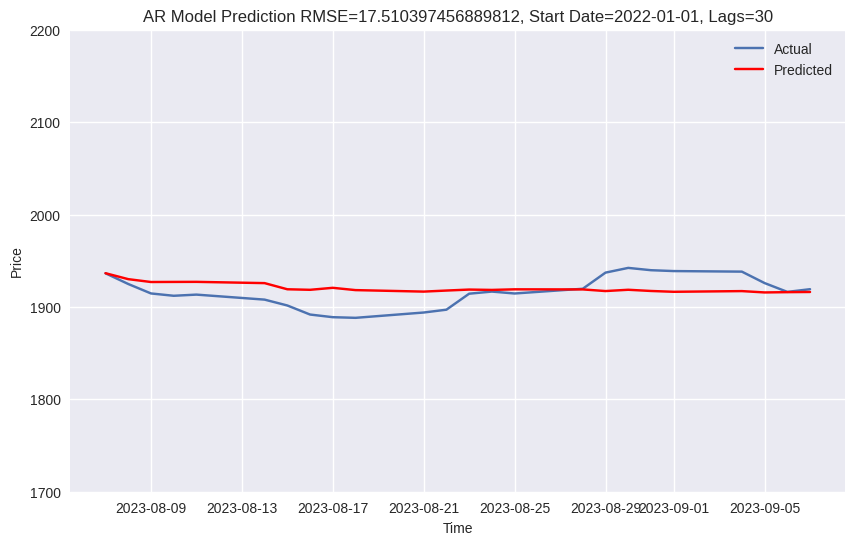

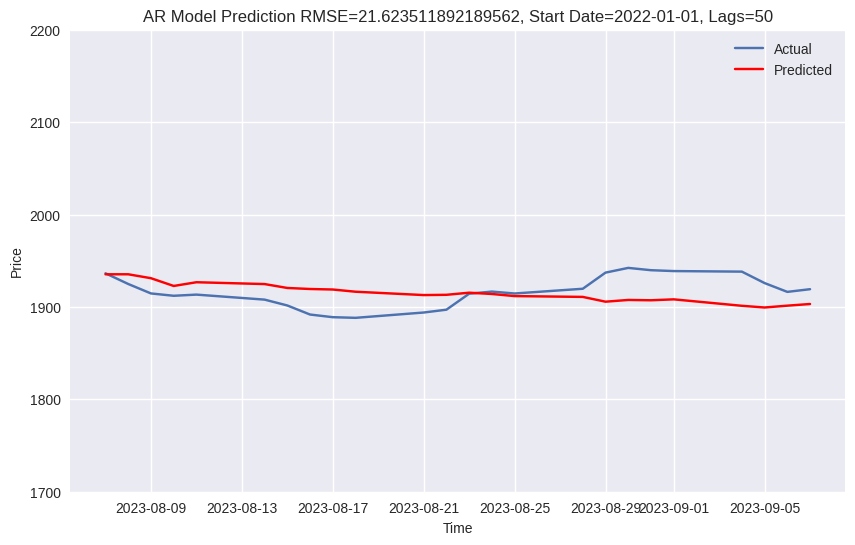

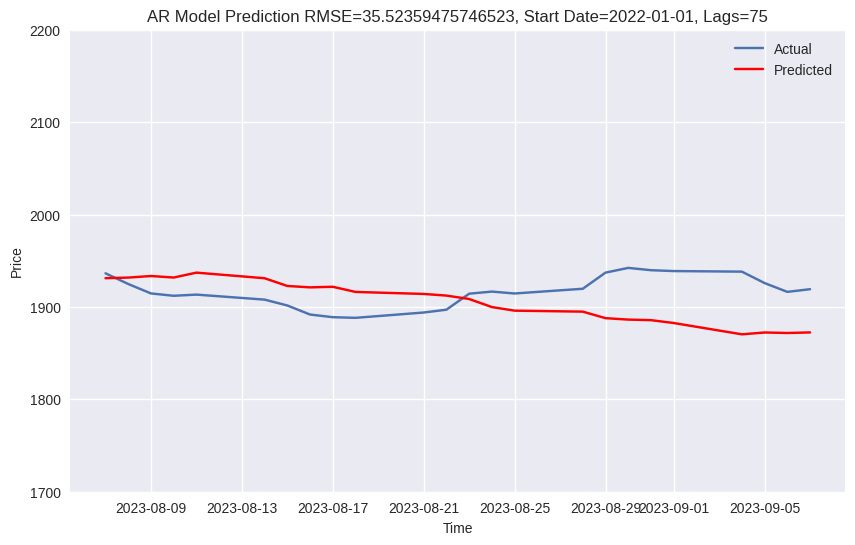

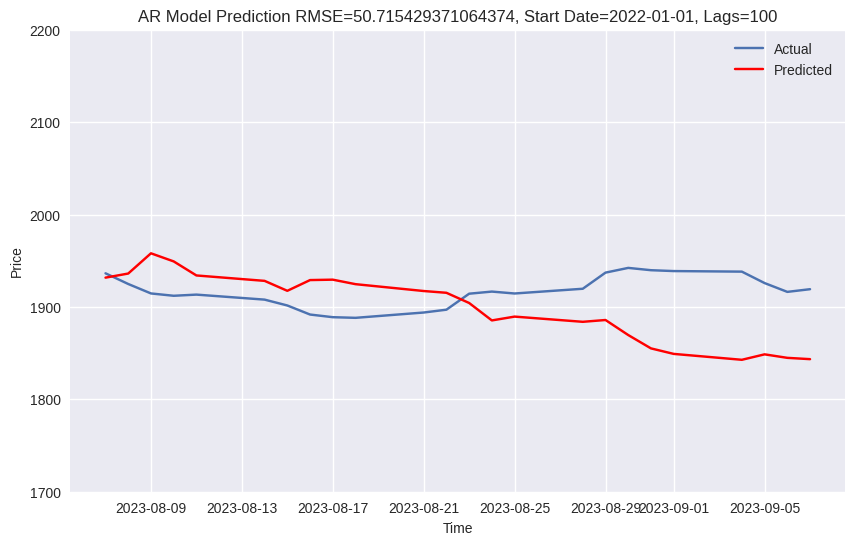

In [23]:
for (predictions, test, rmse, start_date, lags) in models.values():
    plot_test_predictions_with_params(test, predictions, rmse, start_date, lags)